In [1]:
! pip3 install --upgrade --quiet google-cloud-aiplatform

# Load ERA5 2021 June & July

In [2]:
!pip install xarray netCDF4 cartopy matplotlib

Copying gs://gencast/ERA5_2021_06/data_stream-oper_stepType-instant.nc...
/ [1 files][225.5 KiB/225.5 KiB]                                                
Operation completed over 1 objects/225.5 KiB.                                    
Copying gs://gencast/ERA5_2021_07/data_stream-oper_stepType-instant.nc...
/ [1 files][453.6 KiB/453.6 KiB]                                                
Operation completed over 1 objects/453.6 KiB.                                    


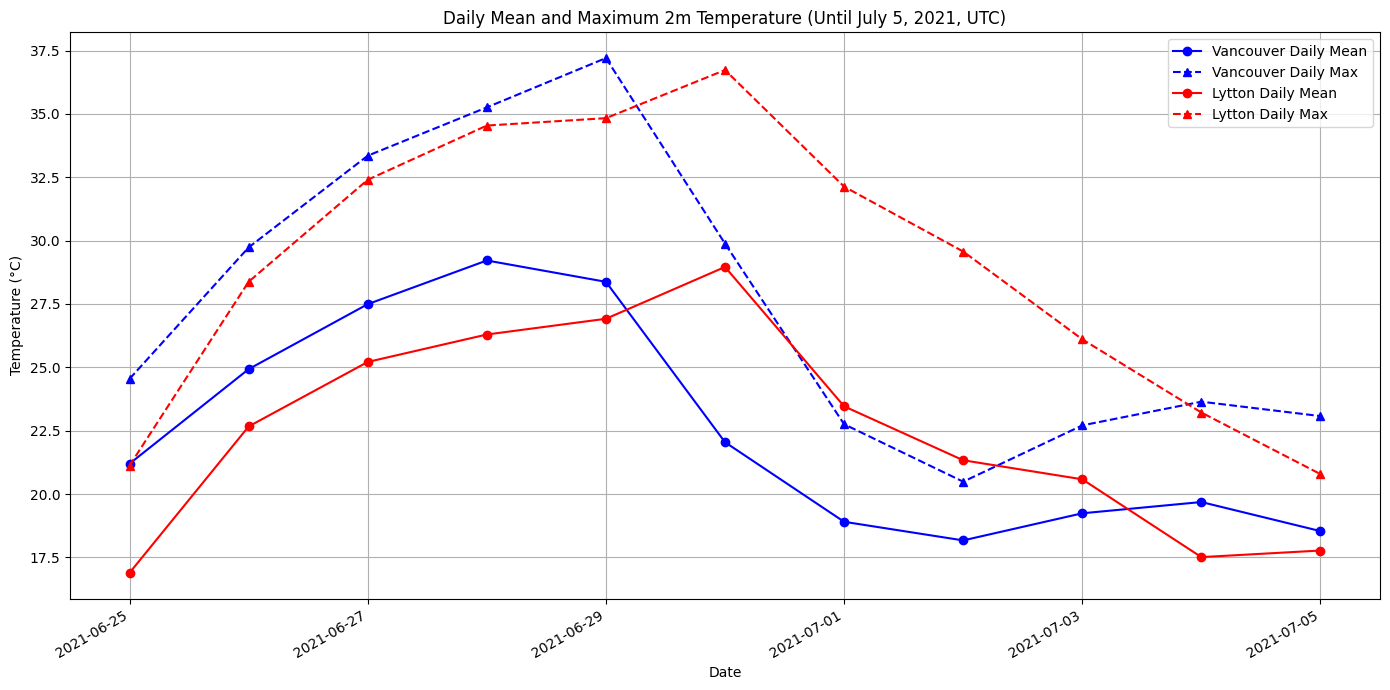

In [1]:
import xarray as xr, matplotlib.pyplot as plt, numpy as np, pandas as pd

# Download ERA5 June and July data
for src, dst in [
    ('gs://gencast/ERA5_2021_06/data_stream-oper_stepType-instant.nc', '/tmp/era5_june.nc'),
    ('gs://gencast/ERA5_2021_07/data_stream-oper_stepType-instant.nc', '/tmp/era5_july.nc')
]:
    !gsutil cp {src} {dst}

# Load and merge datasets
ds = xr.concat([
    xr.open_dataset('/tmp/era5_june.nc', engine='netcdf4'),
    xr.open_dataset('/tmp/era5_july.nc', engine='netcdf4')
], dim="valid_time")

# Location coordinates
locs = {'Vancouver': (49.28, -123.12), 'Lytton': (50.68, -121.95)}
cutoff = pd.to_datetime("2021-07-05")

# Extract 2m temperature, convert to °C, and compute daily stats (filtered to July 5)
daily_stats = {}
for name, (lat, lon) in locs.items():
    da = ds['t2m'].sel(latitude=lat, longitude=lon, method='nearest') - 273.15
    series = pd.Series(da.values, index=pd.to_datetime(da.valid_time.values))
    daily = series.groupby(series.index.date)
    daily_stats[name] = {
        'mean': daily.mean()[lambda d: pd.to_datetime(d.index) <= cutoff],
        'max':  daily.max()[lambda d: pd.to_datetime(d.index) <= cutoff]
    }

# Plot
plt.figure(figsize=(14, 7))
styles = {'Vancouver': 'blue', 'Lytton': 'red'}
markers = {'mean': 'o', 'max': '^'}
for name, stats in daily_stats.items():
    for stat, style in stats.items():
        plt.plot(style.index, style, label=f"{name} Daily {stat.title()}",
                 color=styles[name], marker=markers[stat], linestyle='--' if stat == 'max' else '-')

plt.title('Daily Mean and Maximum 2m Temperature (Until July 5, 2021, UTC)')
plt.xlabel('Date'); plt.ylabel('Temperature (°C)')
plt.legend(); plt.grid(True)
plt.gcf().autofmt_xdate(); plt.tight_layout()
plt.show()

ds.close()


# 14-day lead time GenCast data all Ensembles

In [4]:
pip install xesmf

Note: you may need to restart the kernel to use updated packages.


### Having 2-day timestamp for example (re-grid, extract by coords, save time-series sequence)

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely import wkt
from scipy.interpolate import griddata
from tqdm import tqdm  # progress bar


Ensemble 0 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 0: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 0 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.11it/s]

Ensemble 0: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 0 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.10it/s]

Ensemble 0: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 0 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

Ensemble 0: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 0 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

Ensemble 0: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 4 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 4: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 4 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.13it/s]

Ensemble 4: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 4 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 4: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 4 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 4: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 4 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.69it/s]

Ensemble 4: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 4 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

Ensemble 4: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 4 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 4: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 4 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 4: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  10%|█         | 5/50 [03:35<32:18, 43.07s/it]

Ensemble 4 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 5 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 5: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 5 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.10it/s]

Ensemble 5: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 5 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 5: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 5 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.87it/s]

Ensemble 5: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 5 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.56it/s]

Ensemble 5: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 5 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.43it/s]

Ensemble 5: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 5 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.36it/s]

Ensemble 5: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 5 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.34it/s]

Ensemble 5: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  12%|█▏        | 6/50 [04:17<31:28, 42.92s/it]

Ensemble 5 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 6 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 6: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 6 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  3.95it/s]

Ensemble 6: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 6 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.04it/s]

Ensemble 6: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 6 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 6: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 6 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 6: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 6 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 6: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 6 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 6: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 6 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 6: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  14%|█▍        | 7/50 [05:00<30:47, 42.97s/it]

Ensemble 6 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 7 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 7: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 7 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.11it/s]

Ensemble 7: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 7 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 7: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 7 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

Ensemble 7: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 7 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.57it/s]

Ensemble 7: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 7 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.45it/s]

Ensemble 7: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 7 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.37it/s]

Ensemble 7: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 7 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.30it/s]

Ensemble 7: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  16%|█▌        | 8/50 [05:44<30:08, 43.06s/it]

Ensemble 7 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 8 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 8: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 8 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.09it/s]

Ensemble 8: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 8 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Ensemble 8: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 8 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.02it/s]

Ensemble 8: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 8 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 8: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 8 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

Ensemble 8: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 8 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 8: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 8 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.38it/s]

Ensemble 8: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  18%|█▊        | 9/50 [06:27<29:25, 43.07s/it]

Ensemble 8 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 9 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 9: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 9 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.13it/s]

Ensemble 9: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 9 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Ensemble 9: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 9 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 9: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 9 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 9: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 9 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.47it/s]

Ensemble 9: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 9 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 9: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 9 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.32it/s]

Ensemble 9: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  20%|██        | 10/50 [07:10<28:41, 43.04s/it]

Ensemble 9 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 10 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 10: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 10 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  3.99it/s]

Ensemble 10: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 10 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.04it/s]

Ensemble 10: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 10 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

Ensemble 10: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 10 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

Ensemble 10: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 10 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 10: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 10 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 10: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 10 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 10: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  22%|██▏       | 11/50 [07:53<28:01, 43.12s/it]

Ensemble 10 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 11 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 11: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 11 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.11it/s]

Ensemble 11: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 11 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.09it/s]

Ensemble 11: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 11 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.03it/s]

Ensemble 11: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 11 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.68it/s]

Ensemble 11: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 11 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.53it/s]

Ensemble 11: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 11 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.44it/s]

Ensemble 11: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 11 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.39it/s]

Ensemble 11: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  24%|██▍       | 12/50 [08:36<27:17, 43.09s/it]

Ensemble 11 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 12 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 12: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 12 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.18it/s]

Ensemble 12: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 12 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.16it/s]

Ensemble 12: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 12 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 12: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 12 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.68it/s]

Ensemble 12: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 12 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.52it/s]

Ensemble 12: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 12 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 12: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 12 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 12: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  26%|██▌       | 13/50 [09:19<26:31, 43.02s/it]

Ensemble 12 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 13 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 13: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 13 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.05it/s]

Ensemble 13: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 13 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 13: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 13 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.98it/s]

Ensemble 13: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 13 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.67it/s]

Ensemble 13: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 13 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 13: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 13 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 13: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 13 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.35it/s]

Ensemble 13: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  28%|██▊       | 14/50 [10:02<25:49, 43.03s/it]

Ensemble 13 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 14 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 14: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 14 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.13it/s]

Ensemble 14: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 14 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.13it/s]

Ensemble 14: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 14 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

Ensemble 14: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 14 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 14: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 14 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 14: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 14 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 14: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 14 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 14: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  30%|███       | 15/50 [10:46<25:12, 43.22s/it]

Ensemble 14 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 15 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 15: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 15 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.05it/s]

Ensemble 15: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 15 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.09it/s]

Ensemble 15: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 15 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 15: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 15 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.68it/s]

Ensemble 15: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 15 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.52it/s]

Ensemble 15: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 15 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 15: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 15 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 15: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  32%|███▏      | 16/50 [11:29<24:31, 43.28s/it]

Ensemble 15 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 16 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 16: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 16 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.07it/s]

Ensemble 16: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 16 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 16: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 16 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.98it/s]

Ensemble 16: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 16 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 16: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 16 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

Ensemble 16: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 16 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.43it/s]

Ensemble 16: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 16 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 16: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  34%|███▍      | 17/50 [12:12<23:48, 43.30s/it]

Ensemble 16 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 17 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 17: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 17 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  3.95it/s]

Ensemble 17: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 17 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.02it/s]

Ensemble 17: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 17 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.94it/s]

Ensemble 17: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 17 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.63it/s]

Ensemble 17: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 17 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.49it/s]

Ensemble 17: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 17 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 17: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 17 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 17: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  36%|███▌      | 18/50 [12:56<23:06, 43.32s/it]

Ensemble 17 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 18 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 18: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 18 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.12it/s]

Ensemble 18: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 18 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.11it/s]

Ensemble 18: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 18 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 18: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 18 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 18: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 18 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 18: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 18 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 18: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 18 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 18: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  38%|███▊      | 19/50 [13:39<22:25, 43.39s/it]

Ensemble 18 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 19 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 19: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 19 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.15it/s]

Ensemble 19: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 19 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.06it/s]

Ensemble 19: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 19 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.98it/s]

Ensemble 19: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 19 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 19: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 19 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 19: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 19 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 19: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 19 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.38it/s]

Ensemble 19: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  40%|████      | 20/50 [14:23<21:41, 43.37s/it]

Ensemble 19 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 20 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 20: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 20 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.14it/s]

Ensemble 20: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 20 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Ensemble 20: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 20 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 20: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 20 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.67it/s]

Ensemble 20: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 20 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

Ensemble 20: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 20 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.43it/s]

Ensemble 20: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 20 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 20: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  42%|████▏     | 21/50 [15:06<20:56, 43.32s/it]

Ensemble 20 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 21 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 21: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 21 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.15it/s]

Ensemble 21: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 21 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Ensemble 21: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 21 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.02it/s]

Ensemble 21: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 21 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 21: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 21 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 21: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 21 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 21: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 21 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 21: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  44%|████▍     | 22/50 [15:49<20:14, 43.39s/it]

Ensemble 21 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 22 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 22: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 22 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.14it/s]

Ensemble 22: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 22 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Ensemble 22: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 22 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.98it/s]

Ensemble 22: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 22 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.65it/s]

Ensemble 22: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 22 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 22: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 22 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.43it/s]

Ensemble 22: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 22 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.34it/s]

Ensemble 22: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  46%|████▌     | 23/50 [16:32<19:28, 43.26s/it]

Ensemble 22 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 23 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 23: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 23 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.16it/s]

Ensemble 23: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 23 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.10it/s]

Ensemble 23: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 23 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 23: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 23 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 23: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 23 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

Ensemble 23: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 23 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.40it/s]

Ensemble 23: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 23 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.35it/s]

Ensemble 23: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  48%|████▊     | 24/50 [17:16<18:44, 43.23s/it]

Ensemble 23 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 24 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 24: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 24 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.14it/s]

Ensemble 24: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 24 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.11it/s]

Ensemble 24: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 24 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 24: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 24 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.65it/s]

Ensemble 24: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 24 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 24: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 24 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 24: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 24 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 24: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  50%|█████     | 25/50 [17:59<18:01, 43.25s/it]

Ensemble 24 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 25 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 25: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 25 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.13it/s]

Ensemble 25: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 25 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.13it/s]

Ensemble 25: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 25 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 25: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 25 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.62it/s]

Ensemble 25: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 25 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.47it/s]

Ensemble 25: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 25 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.39it/s]

Ensemble 25: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 25 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.31it/s]

Ensemble 25: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  52%|█████▏    | 26/50 [18:42<17:18, 43.26s/it]

Ensemble 25 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 26 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 26: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 26 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.09it/s]

Ensemble 26: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 26 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 26: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 26 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 26: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 26 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

Ensemble 26: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 26 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 26: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 26 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 26: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 26 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 26: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  54%|█████▍    | 27/50 [19:25<16:31, 43.13s/it]

Ensemble 26 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 27 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 27: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 27 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  3.97it/s]

Ensemble 27: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 27 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.06it/s]

Ensemble 27: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 27 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 27: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 27 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 27: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 27 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 27: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 27 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 27: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 27 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 27: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  56%|█████▌    | 28/50 [20:08<15:49, 43.15s/it]

Ensemble 27 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 28 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 28: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 28 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  3.98it/s]

Ensemble 28: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 28 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.06it/s]

Ensemble 28: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 28 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

Ensemble 28: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 28 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 28: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 28 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

Ensemble 28: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 28 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 28: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 28 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 28: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  58%|█████▊    | 29/50 [20:52<15:07, 43.23s/it]

Ensemble 28 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 29 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 29: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 29 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.03it/s]

Ensemble 29: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 29 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 29: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 29 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 29: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 29 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.67it/s]

Ensemble 29: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 29 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

Ensemble 29: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 29 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 29: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 29 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 29: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  60%|██████    | 30/50 [21:35<14:25, 43.27s/it]

Ensemble 29 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 30 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 30: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 30 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.07it/s]

Ensemble 30: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 30 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.06it/s]

Ensemble 30: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 30 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.90it/s]

Ensemble 30: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 30 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.59it/s]

Ensemble 30: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 30 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.46it/s]

Ensemble 30: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 30 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.40it/s]

Ensemble 30: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 30 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.35it/s]

Ensemble 30: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  62%|██████▏   | 31/50 [22:18<13:40, 43.16s/it]

Ensemble 30 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 31 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 31: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 31 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.04it/s]

Ensemble 31: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 31 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.09it/s]

Ensemble 31: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 31 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 31: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 31 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

Ensemble 31: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 31 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.43it/s]

Ensemble 31: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 31 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.37it/s]

Ensemble 31: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 31 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.34it/s]

Ensemble 31: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  64%|██████▍   | 32/50 [23:01<12:57, 43.19s/it]

Ensemble 31 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 32 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 32: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 32 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.14it/s]

Ensemble 32: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 32 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.10it/s]

Ensemble 32: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 32 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.98it/s]

Ensemble 32: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 32 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

Ensemble 32: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 32 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 32: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 32 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.40it/s]

Ensemble 32: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 32 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.35it/s]

Ensemble 32: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  66%|██████▌   | 33/50 [23:44<12:13, 43.17s/it]

Ensemble 32 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 33 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 33: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 33 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.12it/s]

Ensemble 33: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 33 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Ensemble 33: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 33 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.94it/s]

Ensemble 33: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 33 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.63it/s]

Ensemble 33: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 33 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.49it/s]

Ensemble 33: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 33 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 33: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 33 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.35it/s]

Ensemble 33: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  68%|██████▊   | 34/50 [24:27<11:29, 43.11s/it]

Ensemble 33 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 34 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 34: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 34 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.15it/s]

Ensemble 34: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 34 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.15it/s]

Ensemble 34: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 34 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 34: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 34 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 34: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 34 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 34: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 34 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.40it/s]

Ensemble 34: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 34 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 34: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  70%|███████   | 35/50 [25:10<10:45, 43.03s/it]

Ensemble 34 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 35 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 35: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 35 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.14it/s]

Ensemble 35: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 35 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Ensemble 35: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 35 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

Ensemble 35: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 35 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.67it/s]

Ensemble 35: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 35 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 35: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 35 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 35: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 35 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 35: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  72%|███████▏  | 36/50 [25:53<10:01, 42.99s/it]

Ensemble 35 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 36 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 36: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 36 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.13it/s]

Ensemble 36: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 36 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.13it/s]

Ensemble 36: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 36 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

Ensemble 36: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 36 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 36: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 36 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.49it/s]

Ensemble 36: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 36 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 36: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 36 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.34it/s]

Ensemble 36: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  74%|███████▍  | 37/50 [26:37<09:21, 43.20s/it]

Ensemble 36 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 37 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 37: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 37 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.12it/s]

Ensemble 37: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 37 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.13it/s]

Ensemble 37: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 37 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.97it/s]

Ensemble 37: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 37 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.65it/s]

Ensemble 37: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 37 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.47it/s]

Ensemble 37: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 37 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 37: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 37 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 37: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  76%|███████▌  | 38/50 [27:20<08:38, 43.21s/it]

Ensemble 37 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 38 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 38: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 38 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.10it/s]

Ensemble 38: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 38 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.06it/s]

Ensemble 38: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 38 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.95it/s]

Ensemble 38: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 38 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.61it/s]

Ensemble 38: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 38 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

Ensemble 38: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 38 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.39it/s]

Ensemble 38: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 38 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.34it/s]

Ensemble 38: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  78%|███████▊  | 39/50 [28:03<07:54, 43.18s/it]

Ensemble 38 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 39 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 39: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 39 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.12it/s]

Ensemble 39: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 39 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  3.97it/s]

Ensemble 39: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 39 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.97it/s]

Ensemble 39: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 39 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.63it/s]

Ensemble 39: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 39 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

Ensemble 39: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 39 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.40it/s]

Ensemble 39: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 39 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 39: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  80%|████████  | 40/50 [28:47<07:13, 43.32s/it]

Ensemble 39 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 40 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 40: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 40 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.02it/s]

Ensemble 40: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 40 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.06it/s]

Ensemble 40: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 40 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 40: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 40 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.65it/s]

Ensemble 40: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 40 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.49it/s]

Ensemble 40: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 40 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 40: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 40 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.35it/s]

Ensemble 40: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  82%|████████▏ | 41/50 [29:30<06:29, 43.32s/it]

Ensemble 40 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 41 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 41: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 41 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.18it/s]

Ensemble 41: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 41 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.14it/s]

Ensemble 41: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 41 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 41: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 41 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

Ensemble 41: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 41 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

Ensemble 41: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 41 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.39it/s]

Ensemble 41: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 41 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 41: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  84%|████████▍ | 42/50 [30:13<05:46, 43.27s/it]

Ensemble 41 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 42 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 42: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 42 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.10it/s]

Ensemble 42: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 42 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 42: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 42 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 42: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 42 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.65it/s]

Ensemble 42: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 42 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 42: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 42 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.40it/s]

Ensemble 42: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 42 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 42: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  86%|████████▌ | 43/50 [30:56<05:01, 43.13s/it]

Ensemble 42 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 43 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 43: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 43 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.15it/s]

Ensemble 43: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 43 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.13it/s]

Ensemble 43: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 43 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.95it/s]

Ensemble 43: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 43 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.63it/s]

Ensemble 43: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 43 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 43: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 43 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.43it/s]

Ensemble 43: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 43 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.38it/s]

Ensemble 43: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  88%|████████▊ | 44/50 [31:39<04:18, 43.04s/it]

Ensemble 43 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 44 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 44: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 44 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.11it/s]

Ensemble 44: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 44 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.10it/s]

Ensemble 44: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 44 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.99it/s]

Ensemble 44: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 44 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 44: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 44 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.50it/s]

Ensemble 44: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 44 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 44: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 44 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.34it/s]

Ensemble 44: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  90%|█████████ | 45/50 [32:22<03:35, 43.16s/it]

Ensemble 44 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 45 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 45: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 45 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.07it/s]

Ensemble 45: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 45 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.09it/s]

Ensemble 45: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 45 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

Ensemble 45: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 45 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 45: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 45 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.52it/s]

Ensemble 45: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 45 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.40it/s]

Ensemble 45: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 45 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 45: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  92%|█████████▏| 46/50 [33:05<02:52, 43.12s/it]

Ensemble 45 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 46 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 46: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 46 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.12it/s]

Ensemble 46: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 46 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.10it/s]

Ensemble 46: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 46 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.00it/s]

Ensemble 46: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 46 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

Ensemble 46: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 46 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.48it/s]

Ensemble 46: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 46 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.41it/s]

Ensemble 46: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 46 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 46: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  94%|█████████▍| 47/50 [33:48<02:09, 43.14s/it]

Ensemble 46 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 47 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 47: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 47 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.03it/s]

Ensemble 47: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 47 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.08it/s]

Ensemble 47: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 47 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.02it/s]

Ensemble 47: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 47 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.69it/s]

Ensemble 47: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 47 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.53it/s]

Ensemble 47: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 47 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.45it/s]

Ensemble 47: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 47 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.37it/s]

Ensemble 47: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  96%|█████████▌| 48/50 [34:31<01:26, 43.04s/it]

Ensemble 47 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 48 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 48: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 48 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.14it/s]

Ensemble 48: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 48 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.10it/s]

Ensemble 48: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 48 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  2.96it/s]

Ensemble 48: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 48 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.65it/s]

Ensemble 48: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 48 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.51it/s]

Ensemble 48: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 48 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.42it/s]

Ensemble 48: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 48 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

Ensemble 48: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members:  98%|█████████▊| 49/50 [35:14<00:43, 43.05s/it]

Ensemble 48 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.



Ensemble 49 Timestamps:   0%|          | 0/8 [00:00<?, ?it/s]

Ensemble 49: Processing timestamp 2021-06-25 00:00:00+00:00



Ensemble 49 Timestamps:  12%|█▎        | 1/8 [00:00<00:01,  4.13it/s]

Ensemble 49: Processing timestamp 2021-06-25 06:00:00+00:00



Ensemble 49 Timestamps:  25%|██▌       | 2/8 [00:00<00:01,  4.13it/s]

Ensemble 49: Processing timestamp 2021-06-25 12:00:00+00:00



Ensemble 49 Timestamps:  38%|███▊      | 3/8 [00:00<00:01,  3.02it/s]

Ensemble 49: Processing timestamp 2021-06-25 18:00:00+00:00



Ensemble 49 Timestamps:  50%|█████     | 4/8 [00:01<00:01,  2.69it/s]

Ensemble 49: Processing timestamp 2021-06-26 00:00:00+00:00



Ensemble 49 Timestamps:  62%|██████▎   | 5/8 [00:01<00:01,  2.54it/s]

Ensemble 49: Processing timestamp 2021-06-26 06:00:00+00:00



Ensemble 49 Timestamps:  75%|███████▌  | 6/8 [00:02<00:00,  2.45it/s]

Ensemble 49: Processing timestamp 2021-06-26 12:00:00+00:00



Ensemble 49 Timestamps:  88%|████████▊ | 7/8 [00:02<00:00,  2.40it/s]

Ensemble 49: Processing timestamp 2021-06-26 18:00:00+00:00



Processing Ensemble Members: 100%|██████████| 50/50 [35:57<00:00, 43.16s/it]

Ensemble 49 complete: 8 timestamps processed, 8 Vancouver values extracted, 8 Lytton values extracted.
Extraction complete for all ensemble members (debug period).


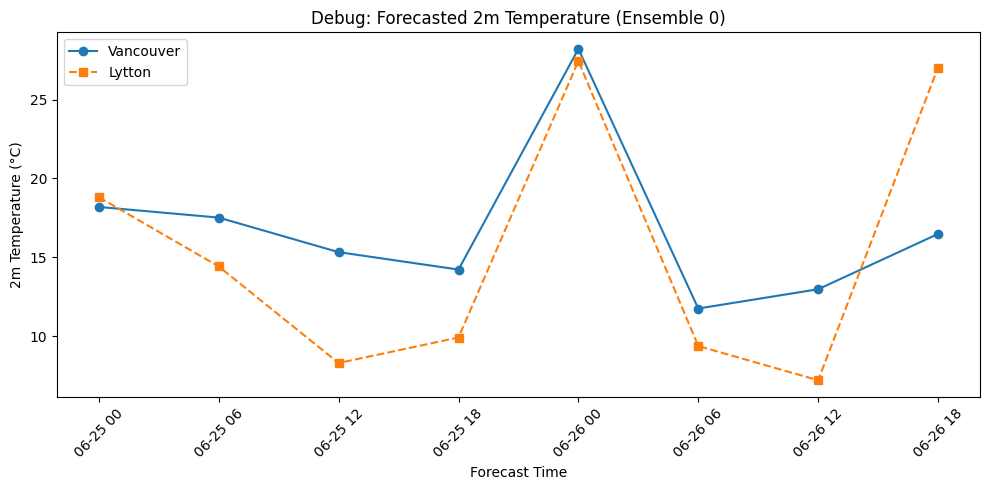

In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely import wkt
from scipy.interpolate import griddata
from tqdm import tqdm  # progress bar

# ==============================================================================
# (A) Assume ERA5 data is already loaded and available in memory as variable ds.
# ==============================================================================
# (This is from your earlier ERA5 code; ds is a concatenated xarray Dataset for June–July.)
# For regridding, extract a representative grid from the first valid_time slice.
era5_grid = ds['t2m'].isel(valid_time=0)  # expects coordinates 'latitude' and 'longitude'

# Create target grid (mesh) from ERA5 grid coordinates.
lon_target = era5_grid.longitude.values
lat_target = era5_grid.latitude.values
lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)

# Define extraction locations (using coordinates similar to your ERA5 example)
locations = {
    'Vancouver': {'latitude': 49.28, 'longitude': -123.12},
    'Lytton':   {'latitude': 50.68, 'longitude': -121.95}
}

# ==============================================================================
# (B) Load Forecast Data (WeatherNext) and restrict to a short period for debugging
# ==============================================================================
csv_files = "gs://gencast/weathernext/weathernext_bc_heatwave_2021_full_14days/*.csv"

cols = [
    "init_time",                   # forecast initialization time
    "forecast_time",               # forecast valid time
    "geography_polygon_text",      # polygon geometry (WKT) for the forecast domain
    "geography_text",              # additional geographic info (e.g. POINT WKT)
    "ensemble_member",             # ensemble member (0 to 49)
    "total_precipitation_12hr",
    "u_component_100m",
    "v_component_100m",
    "u_component_10m",
    "v_component_10m",
    "temp_2m",                     # forecasted 2m temperature (in Kelvin)
    "mean_sea_level_pressure",
    "sea_surface_temperature"
]

useful_cols = [
    "init_time",
    "forecast_time",
    "geography_polygon_text",
    "geography_text",
    "ensemble_member",
    "temp_2m"
]

# Read the CSV files lazily.
ddf = dd.read_csv(csv_files, names=cols, header=None, assume_missing=True)

# Convert time columns to datetime.
ddf["init_time"] = dd.to_datetime(ddf["init_time"], errors="coerce")
ddf["forecast_time"] = dd.to_datetime(ddf["forecast_time"], errors="coerce")

# Keep only useful columns.
ddf = ddf[useful_cols]

# For debugging, restrict the period to a short time span.
# For example, two days with 6-hourly timestamps: 2021-06-25 to 2021-06-26 18:00:00.
start_date = "2021-06-25"
end_date = "2021-06-26 18:00:00"
ddf = ddf[(ddf["forecast_time"] >= start_date) & (ddf["forecast_time"] <= end_date)]

# ==============================================================================
# (C) Define a function to regrid a timestamp’s forecast data using SciPy's griddata.
# ==============================================================================
def regrid_polygon_to_era5_grid(timestamp_df, lon_mesh, lat_mesh):
    """
    For a given timestamp (as a pandas DataFrame), this function:
      - Converts the forecast polygon (WKT) to its centroid (longitude, latitude).
      - Uses SciPy's griddata to interpolate the scattered forecast temp_2m values onto the ERA5 grid.
    
    Parameters:
      timestamp_df : pandas DataFrame for a single forecast timestamp.
      lon_mesh, lat_mesh : 2D arrays that define the ERA5 target grid.
    
    Returns:
      grid_temp : a 2D numpy array (in Kelvin) of the forecasted temperature interpolated onto the ERA5 grid.
    """
    df = timestamp_df.copy()
    # Compute centroid coordinates from the polygon.
    df["centroid_lon"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.x)
    df["centroid_lat"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.y)
    
    # Build the array of points and temperature values.
    points = np.column_stack((df["centroid_lon"].values, df["centroid_lat"].values))
    values = df["temp_2m"].values
    
    # Interpolate using linear method.
    grid_temp = griddata(points, values, (lon_mesh, lat_mesh), method='linear')
    return grid_temp

# ==============================================================================
# (D) Loop over each ensemble member and extract time-series data with progress bars.
# ==============================================================================
all_ensemble_results = {}

# Loop over ensemble members (0 to 49) with a progress bar.
for ens in tqdm(range(50), desc="Processing Ensemble Members"):
    # Subset current ensemble and convert to pandas.
    ddf_ens = ddf[ddf["ensemble_member"] == ens].compute()
    
    # Confirm the forecast period (date filter already applied).
    ddf_ens = ddf_ens[(ddf_ens["forecast_time"] >= start_date) & 
                      (ddf_ens["forecast_time"] <= end_date)]
    
    # Initialize lists to hold extracted (timestamp, temp in °C) pairs.
    ens_ts_vancouver = []
    ens_ts_lytton = []
    
    # Get unique forecast timestamps and sort them.
    timestamps = sorted(ddf_ens["forecast_time"].unique())
    
    # Loop over timestamps with an inner progress bar.
    for ts in tqdm(timestamps, desc=f"Ensemble {ens} Timestamps", leave=False):
        print(f"Ensemble {ens}: Processing timestamp {ts}")
        
        # Subset rows for this timestamp.
        ts_df = ddf_ens[ddf_ens["forecast_time"] == ts]
        
        # Regrid the scattered forecast values onto the ERA5 grid.
        try:
            grid_temp = regrid_polygon_to_era5_grid(ts_df, lon_mesh, lat_mesh)
        except Exception as e:
            print(f"Error during regridding for timestamp {ts} in ensemble {ens}: {e}")
            continue
        
        if grid_temp is None:
            print(f"Griddata returned None for timestamp {ts} in ensemble {ens}")
            continue
        
        # Get indices for the two extraction points.
        v_lon, v_lat = locations['Vancouver']['longitude'], locations['Vancouver']['latitude']
        l_lon, l_lat = locations['Lytton']['longitude'], locations['Lytton']['latitude']
        v_lon_idx = np.abs(lon_target - v_lon).argmin()
        v_lat_idx = np.abs(lat_target - v_lat).argmin()
        l_lon_idx = np.abs(lon_target - l_lon).argmin()
        l_lat_idx = np.abs(lat_target - l_lat).argmin()
        
        # Extract temperature at the nearest grid points.
        try:
            temp_vancouver_K = grid_temp[v_lat_idx, v_lon_idx]
            temp_lytton_K   = grid_temp[l_lat_idx, l_lon_idx]
        except Exception as e:
            print(f"Error extracting grid values for timestamp {ts} in ensemble {ens}: {e}")
            continue
        
        if np.isnan(temp_vancouver_K) or np.isnan(temp_lytton_K):
            print(f"NaN value encountered at timestamp {ts} in ensemble {ens}")
            continue
        
        # Convert from Kelvin to Celsius.
        temp_vancouver_C = temp_vancouver_K - 273.15
        temp_lytton_C   = temp_lytton_K - 273.15
        
        # Append the results.
        ens_ts_vancouver.append((ts, temp_vancouver_C))
        ens_ts_lytton.append((ts, temp_lytton_C))
    
    # Convert to DataFrames and store in results.
    df_vancouver = pd.DataFrame(ens_ts_vancouver, columns=["forecast_time", "temp_2m"])
    df_lytton = pd.DataFrame(ens_ts_lytton, columns=["forecast_time", "temp_2m"])
    all_ensemble_results[ens] = {"Vancouver": df_vancouver, "Lytton": df_lytton}
    
    # Optionally, print a summary for the current ensemble.
    print(f"Ensemble {ens} complete: {len(timestamps)} timestamps processed, "
          f"{len(df_vancouver)} Vancouver values extracted, {len(df_lytton)} Lytton values extracted.")
    
print("Extraction complete for all ensemble members (debug period).")

# ==============================================================================
# (E) Plot Example: Ensemble Member 0 Time-Series for Vancouver and Lytton
# ==============================================================================
ens0_vancouver = all_ensemble_results[0]["Vancouver"]
ens0_lytton    = all_ensemble_results[0]["Lytton"]

plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(ens0_vancouver["forecast_time"]), ens0_vancouver["temp_2m"],
         marker="o", linestyle="-", label="Vancouver")
plt.plot(pd.to_datetime(ens0_lytton["forecast_time"]), ens0_lytton["temp_2m"],
         marker="s", linestyle="--", label="Lytton")
plt.xlabel("Forecast Time")
plt.ylabel("2m Temperature (°C)")
plt.title("Debug: Forecasted 2m Temperature (Ensemble 0)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
all_ensemble_results[5]

{'Vancouver':               forecast_time    temp_2m
 0 2021-06-25 00:00:00+00:00  23.518732
 1 2021-06-25 06:00:00+00:00  11.993372
 2 2021-06-25 12:00:00+00:00  15.260095
 3 2021-06-25 18:00:00+00:00  19.573602
 4 2021-06-26 00:00:00+00:00  15.238428
 5 2021-06-26 06:00:00+00:00  17.487115
 6 2021-06-26 12:00:00+00:00  12.636041
 7 2021-06-26 18:00:00+00:00  26.767999,
 'Lytton':               forecast_time    temp_2m
 0 2021-06-25 00:00:00+00:00  18.385095
 1 2021-06-25 06:00:00+00:00   7.363336
 2 2021-06-25 12:00:00+00:00  11.849420
 3 2021-06-25 18:00:00+00:00  15.297388
 4 2021-06-26 00:00:00+00:00  17.819421
 5 2021-06-26 06:00:00+00:00  12.862512
 6 2021-06-26 12:00:00+00:00   7.634943
 7 2021-06-26 18:00:00+00:00  20.281427}

### Running all timestamps

Processing Ensemble Members:   2%|▏         | 1/50 [00:58<47:24, 58.04s/it]

Ensemble 0 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensemble Members:  86%|████████▌ | 43/50 [41:31<06:44, 57.81s/it]

Ensemble 42 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensemble Members:  88%|████████▊ | 44/50 [42:29<05:46, 57.81s/it]

Ensemble 43 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensemble Members:  90%|█████████ | 45/50 [43:27<04:49, 57.97s/it]

Ensemble 44 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensemble Members:  92%|█████████▏| 46/50 [44:24<03:51, 57.86s/it]

Ensemble 45 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensemble Members:  94%|█████████▍| 47/50 [45:22<02:53, 57.75s/it]

Ensemble 46 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensemble Members:  96%|█████████▌| 48/50 [46:20<01:55, 57.74s/it]

Ensemble 47 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensemble Members:  98%|█████████▊| 49/50 [47:17<00:57, 57.71s/it]

Ensemble 48 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensemble Members: 100%|██████████| 50/50 [48:15<00:00, 57.91s/it]

Ensemble 49 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.
Extraction and aggregation complete for all ensemble members.


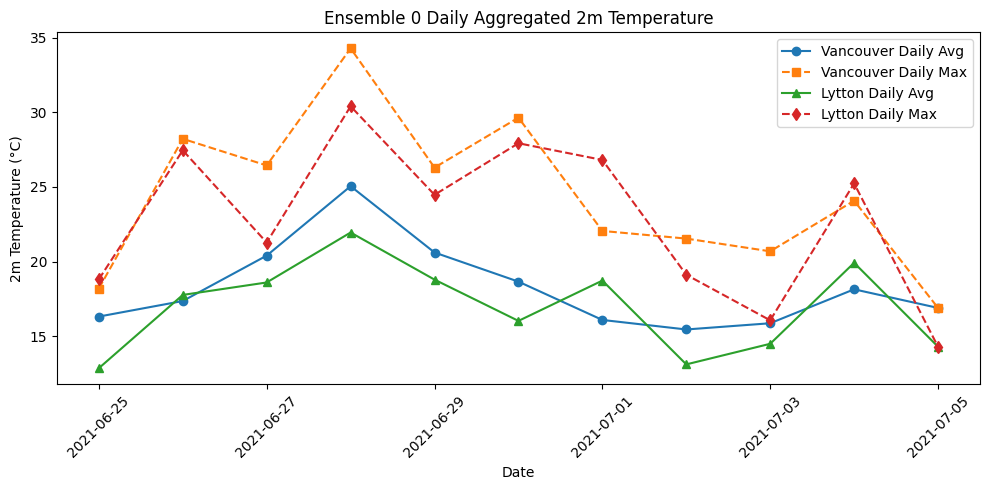

In [ ]:
import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely import wkt
from scipy.interpolate import griddata
from tqdm import tqdm

# ==============================================================================
# (A) ERA5 Setup: assume ds is already in memory.
# ==============================================================================
# Example: ds is already loaded as:
# ds = xr.concat([xr.open_dataset('/tmp/era5_june.nc'),
#                 xr.open_dataset('/tmp/era5_july.nc')],
#                dim="valid_time")
#
# Extract a representative grid from the first valid_time slice.
era5_grid = ds['t2m'].isel(valid_time=0)  # expects coordinates 'latitude' and 'longitude'
lon_target = era5_grid.longitude.values
lat_target = era5_grid.latitude.values
lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)

# Define the extraction locations (using ERA5 coordinates, adjust if needed):
locations = {
    'Vancouver': {'latitude': 49.28, 'longitude': -123.12},
    'Lytton':   {'latitude': 50.68, 'longitude': -121.95}
}

# ==============================================================================
# (B) Load Forecast Data from WeatherNext and Filter Dates:
# ==============================================================================
csv_files = "gs://gencast/weathernext/weathernext_bc_heatwave_2021_full_14days/*.csv"

cols = [
    "init_time",                   # forecast initialization time
    "forecast_time",               # forecast valid time
    "geography_polygon_text",      # polygon geometry (WKT) for forecast domain
    "geography_text",              # additional geographic info (e.g. POINT WKT)
    "ensemble_member",             # ensemble member (0 to 49)
    "total_precipitation_12hr",
    "u_component_100m",
    "v_component_100m",
    "u_component_10m",
    "v_component_10m",
    "temp_2m",                     # forecasted 2m temperature (in Kelvin)
    "mean_sea_level_pressure",
    "sea_surface_temperature"
]

# We only need a subset of columns:
useful_cols = [
    "init_time",
    "forecast_time",
    "geography_polygon_text",
    "geography_text",
    "ensemble_member",
    "temp_2m"
]

# Read CSV files lazily using Dask.
ddf = dd.read_csv(csv_files, names=cols, header=None, assume_missing=True)

# Convert time columns to datetime.
ddf["init_time"] = dd.to_datetime(ddf["init_time"], errors="coerce")
ddf["forecast_time"] = dd.to_datetime(ddf["forecast_time"], errors="coerce")

# Restrict to the useful columns.
ddf = ddf[useful_cols]

# Filter the forecast period to 2021-06-25 to 2021-07-05.
ddf = ddf[(ddf["forecast_time"] >= "2021-06-25") & (ddf["forecast_time"] <= "2021-07-05")]

# ==============================================================================
# (C) Define Regridding Function using SciPy's griddata:
# ==============================================================================
def regrid_polygon_to_era5_grid(timestamp_df, lon_mesh, lat_mesh):
    """
    For a given forecast timestamp (pandas DataFrame), this function:
      - Computes the centroid (lon, lat) from the polygon (WKT).
      - Uses SciPy's griddata to interpolate the scattered temperature values (temp_2m)
        onto the ERA5 grid.
    
    Parameters:
      timestamp_df : pandas DataFrame for a single forecast time.
      lon_mesh, lat_mesh : 2D arrays (from np.meshgrid) defining the ERA5 grid.
    
    Returns:
      grid_temp : a 2D numpy array (in Kelvin) of interpolated temperature values.
    """
    df = timestamp_df.copy()
    # Compute centroids.
    df["centroid_lon"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.x)
    df["centroid_lat"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.y)
    
    # Form an array of (lon, lat) points and corresponding temp values.
    points = np.column_stack((df["centroid_lon"].values, df["centroid_lat"].values))
    values = df["temp_2m"].values
    
    # Interpolate using linear method.
    grid_temp = griddata(points, values, (lon_mesh, lat_mesh), method='linear')
    return grid_temp

# ==============================================================================
# (D) Process All Ensemble Members, Extract Raw and Daily-Aggregated Data, and Save Results:
# ==============================================================================
# Create output directories.
os.makedirs("ensemble_outputs/raw", exist_ok=True)
os.makedirs("ensemble_outputs/daily", exist_ok=True)

all_ensemble_results = {}  # Optionally store the full results in-memory.

# Progress bar over ensemble members.
for ens in tqdm(range(50), desc="Processing Ensemble Members"):
    # Subset current ensemble and convert to pandas.
    ddf_ens = ddf[ddf["ensemble_member"] == ens].compute()
    ddf_ens = ddf_ens[(ddf_ens["forecast_time"] >= "2021-06-25") & 
                      (ddf_ens["forecast_time"] <= "2021-07-05")]
    
    # Lists to store raw 6-hourly extraction results.
    ens_ts_vancouver = []
    ens_ts_lytton = []
    
    # Get sorted unique forecast timestamps.
    timestamps = sorted(ddf_ens["forecast_time"].unique())
    
    for ts in timestamps:
        # Subset rows for this forecast timestamp.
        ts_df = ddf_ens[ddf_ens["forecast_time"] == ts]
        
        try:
            grid_temp = regrid_polygon_to_era5_grid(ts_df, lon_mesh, lat_mesh)
        except Exception as e:
            print(f"Error during regridding for timestamp {ts} in ensemble {ens}: {e}")
            continue
        
        if grid_temp is None:
            print(f"Griddata returned None for timestamp {ts} in ensemble {ens}")
            continue
        
        # Find nearest grid indices for extraction.
        v_lon, v_lat = locations['Vancouver']['longitude'], locations['Vancouver']['latitude']
        l_lon, l_lat = locations['Lytton']['longitude'], locations['Lytton']['latitude']
        v_lon_idx = np.abs(lon_target - v_lon).argmin()
        v_lat_idx = np.abs(lat_target - v_lat).argmin()
        l_lon_idx = np.abs(lon_target - l_lon).argmin()
        l_lat_idx = np.abs(lat_target - l_lat).argmin()
        
        try:
            temp_vancouver_K = grid_temp[v_lat_idx, v_lon_idx]
            temp_lytton_K = grid_temp[l_lat_idx, l_lon_idx]
        except Exception as e:
            print(f"Error extracting grid values for timestamp {ts} in ensemble {ens}: {e}")
            continue
        
        if np.isnan(temp_vancouver_K) or np.isnan(temp_lytton_K):
            print(f"NaN value encountered at timestamp {ts} in ensemble {ens}")
            continue
        
        # Convert Kelvin to Celsius.
        temp_vancouver_C = temp_vancouver_K - 273.15
        temp_lytton_C = temp_lytton_K - 273.15
        
        ens_ts_vancouver.append((ts, temp_vancouver_C))
        ens_ts_lytton.append((ts, temp_lytton_C))
    
    # Convert raw results to DataFrames.
    df_vancouver = pd.DataFrame(ens_ts_vancouver, columns=["forecast_time", "temp_2m"])
    df_lytton = pd.DataFrame(ens_ts_lytton, columns=["forecast_time", "temp_2m"])
    
    # Save raw time series to CSV.
    raw_vancouver_file = f"ensemble_outputs/raw/ensemble_{ens}_vancouver.csv"
    raw_lytton_file = f"ensemble_outputs/raw/ensemble_{ens}_lytton.csv"
    df_vancouver.to_csv(raw_vancouver_file, index=False)
    df_lytton.to_csv(raw_lytton_file, index=False)
    
    # Compute daily aggregated stats for each location.
    # Convert forecast_time column to datetime and extract the date.
    df_vancouver["date"] = pd.to_datetime(df_vancouver["forecast_time"]).dt.floor("D")
    daily_vancouver = df_vancouver.groupby("date").agg(
        daily_avg=("temp_2m", "mean"),
        daily_max=("temp_2m", "max")
    ).reset_index()
    
    df_lytton["date"] = pd.to_datetime(df_lytton["forecast_time"]).dt.floor("D")
    daily_lytton = df_lytton.groupby("date").agg(
        daily_avg=("temp_2m", "mean"),
        daily_max=("temp_2m", "max")
    ).reset_index()
    
    # Save daily aggregated results to CSV.
    daily_vancouver_file = f"ensemble_outputs/daily/ensemble_{ens}_vancouver_daily.csv"
    daily_lytton_file = f"ensemble_outputs/daily/ensemble_{ens}_lytton_daily.csv"
    daily_vancouver.to_csv(daily_vancouver_file, index=False)
    daily_lytton.to_csv(daily_lytton_file, index=False)
    
    # Optionally store in-memory.
    all_ensemble_results[ens] = {
        "raw": {"Vancouver": df_vancouver, "Lytton": df_lytton},
        "daily": {"Vancouver": daily_vancouver, "Lytton": daily_lytton}
    }
    
    print(f"Ensemble {ens} complete: {len(timestamps)} timestamps processed, "
          f"{len(df_vancouver)} raw Vancouver values, {len(df_lytton)} raw Lytton values.")

print("Extraction and aggregation complete for all ensemble members.")

# ==============================================================================
# (E) (Optional) Example Plot for Ensemble Member 0 Daily Aggregated Data:
# ==============================================================================
ens0_van_daily = all_ensemble_results[0]["daily"]["Vancouver"]
ens0_lyt_daily = all_ensemble_results[0]["daily"]["Lytton"]

plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(ens0_van_daily["date"]), ens0_van_daily["daily_avg"],
         marker="o", linestyle="-", label="Vancouver Daily Avg")
plt.plot(pd.to_datetime(ens0_van_daily["date"]), ens0_van_daily["daily_max"],
         marker="s", linestyle="--", label="Vancouver Daily Max")
plt.plot(pd.to_datetime(ens0_lyt_daily["date"]), ens0_lyt_daily["daily_avg"],
         marker="^", linestyle="-", label="Lytton Daily Avg")
plt.plot(pd.to_datetime(ens0_lyt_daily["date"]), ens0_lyt_daily["daily_max"],
         marker="d", linestyle="--", label="Lytton Daily Max")
plt.xlabel("Date")
plt.ylabel("2m Temperature (°C)")
plt.title("Ensemble 0 Daily Aggregated 2m Temperature")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
all_ensemble_results[5]

{'raw': {'Vancouver':                forecast_time    temp_2m                      date
  0  2021-06-25 00:00:00+00:00  23.518732 2021-06-25 00:00:00+00:00
  1  2021-06-25 06:00:00+00:00  11.993372 2021-06-25 00:00:00+00:00
  2  2021-06-25 12:00:00+00:00  15.260095 2021-06-25 00:00:00+00:00
  3  2021-06-25 18:00:00+00:00  19.573602 2021-06-25 00:00:00+00:00
  4  2021-06-26 00:00:00+00:00  15.238428 2021-06-26 00:00:00+00:00
  5  2021-06-26 06:00:00+00:00  17.487115 2021-06-26 00:00:00+00:00
  6  2021-06-26 12:00:00+00:00  12.636041 2021-06-26 00:00:00+00:00
  7  2021-06-26 18:00:00+00:00  26.767999 2021-06-26 00:00:00+00:00
  8  2021-06-27 00:00:00+00:00  18.430811 2021-06-27 00:00:00+00:00
  9  2021-06-27 06:00:00+00:00  21.571771 2021-06-27 00:00:00+00:00
  10 2021-06-27 12:00:00+00:00  14.484796 2021-06-27 00:00:00+00:00
  11 2021-06-27 18:00:00+00:00  24.089899 2021-06-27 00:00:00+00:00
  12 2021-06-28 00:00:00+00:00  21.472559 2021-06-28 00:00:00+00:00
  13 2021-06-28 06:00:00+00:

In [14]:
import os
import glob
import pandas as pd
from google.cloud import storage

# -------------------------------
# (1) Combine Daily Aggregated Files
# -------------------------------

# Define the local folder where your per-ensemble daily files were saved.
# The previous code saved files under:
#   ensemble_outputs/daily/ensemble_{ens}_vancouver_daily.csv
#   ensemble_outputs/daily/ensemble_{ens}_lytton_daily.csv
daily_dir = "ensemble_outputs/daily"
combined_dir = "combined_outputs"
os.makedirs(combined_dir, exist_ok=True)

# Process Vancouver files.
vancouver_files = glob.glob(os.path.join(daily_dir, "ensemble_*_vancouver_daily.csv"))
van_list = []
for file in vancouver_files:
    df = pd.read_csv(file)
    # Extract ensemble id from file name; expected format: ensemble_{ens}_vancouver_daily.csv
    try:
        ens_id = os.path.basename(file).split("_")[1]
    except Exception as e:
        ens_id = None
    df["ensemble_member"] = ens_id
    van_list.append(df)

if van_list:
    combined_vancouver = pd.concat(van_list, ignore_index=True)
    # Save with a filename that clarifies these are 14-day forecast data.
    van_output = os.path.join(combined_dir, "vancouver_daily_forecast_14day.csv")
    combined_vancouver.to_csv(van_output, index=False)
    print("Combined Vancouver daily forecast saved to:", van_output)
else:
    print("No Vancouver daily files found.")

# Process Lytton files.
lytton_files = glob.glob(os.path.join(daily_dir, "ensemble_*_lytton_daily.csv"))
lyt_list = []
for file in lytton_files:
    df = pd.read_csv(file)
    try:
        ens_id = os.path.basename(file).split("_")[1]
    except Exception as e:
        ens_id = None
    df["ensemble_member"] = ens_id
    lyt_list.append(df)

if lyt_list:
    combined_lytton = pd.concat(lyt_list, ignore_index=True)
    lyt_output = os.path.join(combined_dir, "lytton_daily_forecast_14day.csv")
    combined_lytton.to_csv(lyt_output, index=False)
    print("Combined Lytton daily forecast saved to:", lyt_output)
else:
    print("No Lytton daily files found.")

Combined Vancouver daily forecast saved to: combined_outputs/vancouver_daily_forecast_14day.csv
Combined Lytton daily forecast saved to: combined_outputs/lytton_daily_forecast_14day.csv


In [15]:
df.head()

,date,daily_avg,daily_max,ensemble_member
0,2021-06-25 00:00:00+00:00,14.756410,19.143640,44
1,2021-06-26 00:00:00+00:00,16.389223,24.845605,44
2,2021-06-27 00:00:00+00:00,20.714700,30.453882,44
3,2021-06-28 00:00:00+00:00,19.896661,23.859216,44
4,2021-06-29 00:00:00+00:00,18.927042,23.768488,44


In [16]:

# -------------------------------
# (2) Upload Combined Files to a Cloud Storage Bucket
# -------------------------------
# Replace 'your-bucket-name' with the name of your target cloud storage bucket.
bucket_name = "gencast"
# Use a destination prefix that makes it clear these are 14-day forecasts.
destination_prefix = "daily_forecast_14day"

# Initialize the Google Cloud Storage client.
client = storage.Client()
bucket = client.bucket(bucket_name)

def upload_file_to_gcs(local_file, bucket, destination_blob_name):
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(local_file)
    print(f"Uploaded {local_file} to gs://{bucket.name}/{destination_blob_name}")

# Upload Vancouver file if it exists.
if os.path.exists(van_output):
    upload_file_to_gcs(van_output, bucket, f"{destination_prefix}/{os.path.basename(van_output)}")
    
# Upload Lytton file if it exists.
if os.path.exists(lyt_output):
    upload_file_to_gcs(lyt_output, bucket, f"{destination_prefix}/{os.path.basename(lyt_output)}")


Uploaded combined_outputs/vancouver_daily_forecast_14day.csv to gs://gencast/daily_forecast_14day/vancouver_daily_forecast_14day.csv
Uploaded combined_outputs/lytton_daily_forecast_14day.csv to gs://gencast/daily_forecast_14day/lytton_daily_forecast_14day.csv


In [23]:
import pandas as pd

# Paths to the combined daily forecast CSV files.
vancouver_file = "combined_outputs/vancouver_daily_forecast_14day.csv"
lytton_file = "combined_outputs/lytton_daily_forecast_14day.csv"

# Load the datasets.
df_vancouver = pd.read_csv(vancouver_file)
df_lytton = pd.read_csv(lytton_file)

# Print the head of each dataset.
print("Head of Vancouver Daily Forecast (14-day):")
print(df_vancouver.head())

print("\nHead of Lytton Daily Forecast (14-day):")
print(df_lytton.head())

Head of Vancouver Daily Forecast (14-day):
                        date  daily_avg  daily_max  ensemble_member
0  2021-06-25 00:00:00+00:00  18.197778  21.798792               22
1  2021-06-26 00:00:00+00:00  14.905954  17.459924               22
2  2021-06-27 00:00:00+00:00  15.881128  18.918329               22
3  2021-06-28 00:00:00+00:00  22.582857  25.924402               22
4  2021-06-29 00:00:00+00:00  19.200380  28.210779               22

Head of Lytton Daily Forecast (14-day):
                        date  daily_avg  daily_max  ensemble_member
0  2021-06-25 00:00:00+00:00  13.322168  15.108362                3
1  2021-06-26 00:00:00+00:00  18.093378  24.140771                3
2  2021-06-27 00:00:00+00:00  16.162355  21.087915                3
3  2021-06-28 00:00:00+00:00  18.430673  24.194513                3
4  2021-06-29 00:00:00+00:00  15.182001  18.609491                3


# 7, 3, 1-day lead

In [45]:
 ds = xr.concat([xr.open_dataset('/tmp/era5_june.nc', engine='netcdf4'),
               xr.open_dataset('/tmp/era5_july.nc', engine='netcdf4')],
               dim="valid_time")
ds.head()

<xarray.Dataset> Size: 708B
Dimensions:     (valid_time: 5, latitude: 5, longitude: 5)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 40B 2021-06-25 ... 2021-06-26
  * latitude    (latitude) float64 40B 60.0 59.75 59.5 59.25 59.0
  * longitude   (longitude) float64 40B -139.0 -138.8 -138.5 -138.2 -138.0
    expver      (valid_time) <U4 80B '0001' '0001' '0001' '0001' '0001'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 500B 280.7 ... 284.8
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-26T16:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [48]:
# 7day

import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely import wkt
from scipy.interpolate import griddata
from tqdm import tqdm

# ==============================================================================
# (A) ERA5 Setup: assume ds is already in memory.
# ==============================================================================
# For example:
# ds = xr.concat([xr.open_dataset('/tmp/era5_june.nc'),
#                 xr.open_dataset('/tmp/era5_july.nc')],
#                dim="valid_time")
era5_grid = ds['t2m'].isel(valid_time=0)  # expects coordinates 'latitude' and 'longitude'
lon_target = era5_grid.longitude.values
lat_target = era5_grid.latitude.values
lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)

# Define the extraction locations (using ERA5 coordinate conventions)
locations = {
    'Vancouver': {'latitude': 49.28, 'longitude': -123.12},
    'Lytton':   {'latitude': 50.68, 'longitude': -121.95}
}

# ==============================================================================
# (B) Load Forecast Data from WeatherNext for 7-day lead and Filter Dates:
# ==============================================================================
csv_files = "gs://gencast/weathernext/weathernext_bc_heatwave_2021_full_7days/*.csv"

cols = [
    "init_time",                   # forecast initialization time
    "forecast_time",               # forecast valid time
    "geography_polygon_text",      # polygon geometry (WKT) for forecast domain
    "geography_text",              # additional geographic info (e.g. POINT WKT)
    "ensemble_member",             # ensemble member (0 to 49)
    "total_precipitation_12hr",
    "u_component_100m",
    "v_component_100m",
    "u_component_10m",
    "v_component_10m",
    "temp_2m",                     # forecasted 2m temperature (in Kelvin)
    "mean_sea_level_pressure",
    "sea_surface_temperature"
]

# We only need a subset of columns:
useful_cols = [
    "init_time",
    "forecast_time",
    "geography_polygon_text",
    "geography_text",
    "ensemble_member",
    "temp_2m"
]

# Read CSV files lazily using Dask.
ddf = dd.read_csv(csv_files, names=cols, header=None, assume_missing=True)

# Convert time columns to datetime.
ddf["init_time"] = dd.to_datetime(ddf["init_time"], errors="coerce")
ddf["forecast_time"] = dd.to_datetime(ddf["forecast_time"], errors="coerce")

# Restrict to the useful columns.
ddf = ddf[useful_cols]

# Use the same forecast period as 14-day: 2021-06-25 to 2021-07-05.
ddf = ddf[(ddf["forecast_time"] >= "2021-06-25") & (ddf["forecast_time"] <= "2021-07-05")]

# ==============================================================================
# (C) Define Regridding Function using SciPy's griddata:
# ==============================================================================
def regrid_polygon_to_era5_grid(timestamp_df, lon_mesh, lat_mesh):
    """
    For a given forecast timestamp (pandas DataFrame), this function:
      - Computes the centroid (lon, lat) from the polygon (WKT).
      - Uses SciPy's griddata to interpolate the scattered temperature values (temp_2m)
        onto the ERA5 grid.
    
    Parameters:
      timestamp_df : pandas DataFrame for a single forecast time.
      lon_mesh, lat_mesh : 2D arrays (from np.meshgrid) defining the ERA5 grid.
    
    Returns:
      grid_temp : a 2D numpy array (in Kelvin) of interpolated temperature values.
    """
    df = timestamp_df.copy()
    df["centroid_lon"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.x)
    df["centroid_lat"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.y)
    points = np.column_stack((df["centroid_lon"].values, df["centroid_lat"].values))
    values = df["temp_2m"].values
    grid_temp = griddata(points, values, (lon_mesh, lat_mesh), method='linear')
    return grid_temp

# ==============================================================================
# (D) Process All Ensemble Members, Extract Raw and Daily-Aggregated Data, and Save Results:
# ==============================================================================
# Create output directories.
os.makedirs("ensemble_outputs/7day/raw", exist_ok=True)
os.makedirs("ensemble_outputs/7day/daily", exist_ok=True)

all_ensemble_results = {}  # Optionally store in-memory results.

# Progress bar over ensemble members.
for ens in tqdm(range(50), desc="Processing Ensembles for 7-day Forecast"):
    # Subset current ensemble and convert to pandas.
    ddf_ens = ddf[ddf["ensemble_member"] == ens].compute()
    ddf_ens = ddf_ens[(ddf_ens["forecast_time"] >= "2021-06-25") & 
                      (ddf_ens["forecast_time"] <= "2021-07-05")]
    
    ens_ts_vancouver = []
    ens_ts_lytton = []
    
    # Get sorted unique forecast timestamps.
    timestamps = sorted(ddf_ens["forecast_time"].unique())
    
    for ts in timestamps:
        ts_df = ddf_ens[ddf_ens["forecast_time"] == ts]
        try:
            grid_temp = regrid_polygon_to_era5_grid(ts_df, lon_mesh, lat_mesh)
        except Exception as e:
            print(f"Error during regridding for timestamp {ts} in ensemble {ens}: {e}")
            continue
        
        if grid_temp is None:
            print(f"Griddata returned None for timestamp {ts} in ensemble {ens}")
            continue
        
        # Determine nearest grid indices for extraction.
        v_lon, v_lat = locations['Vancouver']['longitude'], locations['Vancouver']['latitude']
        l_lon, l_lat = locations['Lytton']['longitude'], locations['Lytton']['latitude']
        v_lon_idx = np.abs(lon_target - v_lon).argmin()
        v_lat_idx = np.abs(lat_target - v_lat).argmin()
        l_lon_idx = np.abs(lon_target - l_lon).argmin()
        l_lat_idx = np.abs(lat_target - l_lat).argmin()
        try:
            temp_vancouver_K = grid_temp[v_lat_idx, v_lon_idx]
            temp_lytton_K = grid_temp[l_lat_idx, l_lon_idx]
        except Exception as e:
            print(f"Error extracting grid values for timestamp {ts} in ensemble {ens}: {e}")
            continue
        
        if np.isnan(temp_vancouver_K) or np.isnan(temp_lytton_K):
            print(f"NaN encountered at timestamp {ts} in ensemble {ens}")
            continue
        
        # Convert from Kelvin to Celsius.
        temp_vancouver_C = temp_vancouver_K - 273.15
        temp_lytton_C = temp_lytton_K - 273.15
        ens_ts_vancouver.append((ts, temp_vancouver_C))
        ens_ts_lytton.append((ts, temp_lytton_C))
    
    # Convert raw results to DataFrames.
    df_vancouver = pd.DataFrame(ens_ts_vancouver, columns=["forecast_time", "temp_2m"])
    df_lytton = pd.DataFrame(ens_ts_lytton, columns=["forecast_time", "temp_2m"])
    
    # Save raw time series to CSV in the correct 7day/raw directory.
    raw_vancouver_file = os.path.join("ensemble_outputs", "7day", "raw", f"ensemble_{ens}_vancouver.csv")
    raw_lytton_file = os.path.join("ensemble_outputs", "7day", "raw", f"ensemble_{ens}_lytton.csv")
    df_vancouver.to_csv(raw_vancouver_file, index=False)
    df_lytton.to_csv(raw_lytton_file, index=False)
    
    # Compute daily aggregated stats for each location.
    df_vancouver["date"] = pd.to_datetime(df_vancouver["forecast_time"]).dt.floor("D")
    daily_vancouver = df_vancouver.groupby("date").agg(
        daily_avg=("temp_2m", "mean"),
        daily_max=("temp_2m", "max")
    ).reset_index()
    
    df_lytton["date"] = pd.to_datetime(df_lytton["forecast_time"]).dt.floor("D")
    daily_lytton = df_lytton.groupby("date").agg(
        daily_avg=("temp_2m", "mean"),
        daily_max=("temp_2m", "max")
    ).reset_index()
    
    # Save daily aggregated results to CSV in the correct 7day/daily directory.
    daily_vancouver_file = os.path.join("ensemble_outputs", "7day", "daily", f"ensemble_{ens}_vancouver_daily.csv")
    daily_lytton_file = os.path.join("ensemble_outputs", "7day", "daily", f"ensemble_{ens}_lytton_daily.csv")
    daily_vancouver.to_csv(daily_vancouver_file, index=False)
    daily_lytton.to_csv(daily_lytton_file, index=False)
    
    # Optionally, store in-memory results (if needed for further processing).
    all_ensemble_results[ens] = {
        "raw": {"Vancouver": df_vancouver, "Lytton": df_lytton},
        "daily": {"Vancouver": daily_vancouver, "Lytton": daily_lytton}
    }
    
    print(f"Ensemble {ens} complete: {len(timestamps)} timestamps processed, "
          f"{len(df_vancouver)} raw Vancouver values, {len(df_lytton)} raw Lytton values.")

print("Extraction and aggregation complete for all ensemble members (7-day).")


Processing Ensembles for 7-day Forecast:   2%|▏         | 1/50 [00:57<47:10, 57.77s/it]

Ensemble 0 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:   4%|▍         | 2/50 [01:55<46:11, 57.75s/it]

Ensemble 1 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:   6%|▌         | 3/50 [02:53<45:10, 57.68s/it]

Ensemble 2 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:   8%|▊         | 4/50 [03:51<44:22, 57.87s/it]

Ensemble 3 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  10%|█         | 5/50 [04:48<43:20, 57.78s/it]

Ensemble 4 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  12%|█▏        | 6/50 [05:46<42:18, 57.69s/it]

Ensemble 5 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  14%|█▍        | 7/50 [06:44<41:30, 57.91s/it]

Ensemble 6 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  16%|█▌        | 8/50 [07:42<40:32, 57.92s/it]

Ensemble 7 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  18%|█▊        | 9/50 [08:41<39:40, 58.05s/it]

Ensemble 8 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  20%|██        | 10/50 [09:38<38:37, 57.95s/it]

Ensemble 9 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  22%|██▏       | 11/50 [10:36<37:40, 57.97s/it]

Ensemble 10 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  24%|██▍       | 12/50 [11:35<36:46, 58.06s/it]

Ensemble 11 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  26%|██▌       | 13/50 [12:32<35:46, 58.01s/it]

Ensemble 12 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  28%|██▊       | 14/50 [13:30<34:44, 57.91s/it]

Ensemble 13 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  30%|███       | 15/50 [14:28<33:44, 57.83s/it]

Ensemble 14 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  32%|███▏      | 16/50 [15:25<32:44, 57.79s/it]

Ensemble 15 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  34%|███▍      | 17/50 [16:23<31:43, 57.67s/it]

Ensemble 16 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  36%|███▌      | 18/50 [17:21<30:48, 57.78s/it]

Ensemble 17 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  38%|███▊      | 19/50 [18:19<29:49, 57.74s/it]

Ensemble 18 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  40%|████      | 20/50 [19:17<28:55, 57.86s/it]

Ensemble 19 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  42%|████▏     | 21/50 [20:15<28:01, 57.97s/it]

Ensemble 20 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  44%|████▍     | 22/50 [21:13<27:03, 57.98s/it]

Ensemble 21 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  46%|████▌     | 23/50 [22:11<26:06, 58.02s/it]

Ensemble 22 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  48%|████▊     | 24/50 [23:09<25:04, 57.87s/it]

Ensemble 23 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  50%|█████     | 25/50 [24:07<24:08, 57.95s/it]

Ensemble 24 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  52%|█████▏    | 26/50 [25:04<23:07, 57.83s/it]

Ensemble 25 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  54%|█████▍    | 27/50 [26:02<22:09, 57.80s/it]

Ensemble 26 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  56%|█████▌    | 28/50 [27:00<21:12, 57.85s/it]

Ensemble 27 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  58%|█████▊    | 29/50 [27:58<20:14, 57.85s/it]

Ensemble 28 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  60%|██████    | 30/50 [28:56<19:18, 57.93s/it]

Ensemble 29 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  62%|██████▏   | 31/50 [29:53<18:18, 57.82s/it]

Ensemble 30 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  64%|██████▍   | 32/50 [30:51<17:20, 57.81s/it]

Ensemble 31 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  66%|██████▌   | 33/50 [31:49<16:21, 57.73s/it]

Ensemble 32 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  68%|██████▊   | 34/50 [32:47<15:24, 57.76s/it]

Ensemble 33 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  70%|███████   | 35/50 [33:45<14:28, 57.89s/it]

Ensemble 34 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  72%|███████▏  | 36/50 [34:43<13:29, 57.85s/it]

Ensemble 35 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  74%|███████▍  | 37/50 [35:41<12:33, 57.99s/it]

Ensemble 36 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  76%|███████▌  | 38/50 [36:39<11:35, 57.95s/it]

Ensemble 37 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  78%|███████▊  | 39/50 [37:36<10:36, 57.89s/it]

Ensemble 38 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  80%|████████  | 40/50 [38:34<09:38, 57.84s/it]

Ensemble 39 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  82%|████████▏ | 41/50 [39:32<08:40, 57.88s/it]

Ensemble 40 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  84%|████████▍ | 42/50 [40:30<07:42, 57.81s/it]

Ensemble 41 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  86%|████████▌ | 43/50 [41:28<06:44, 57.82s/it]

Ensemble 42 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  88%|████████▊ | 44/50 [42:26<05:47, 57.88s/it]

Ensemble 43 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  90%|█████████ | 45/50 [43:24<04:49, 57.94s/it]

Ensemble 44 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  92%|█████████▏| 46/50 [44:22<03:52, 58.02s/it]

Ensemble 45 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  94%|█████████▍| 47/50 [45:20<02:54, 58.11s/it]

Ensemble 46 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  96%|█████████▌| 48/50 [46:19<01:56, 58.16s/it]

Ensemble 47 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast:  98%|█████████▊| 49/50 [47:17<00:58, 58.12s/it]

Ensemble 48 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.


Processing Ensembles for 7-day Forecast: 100%|██████████| 50/50 [48:14<00:00, 57.90s/it]

Ensemble 49 complete: 41 timestamps processed, 41 raw Vancouver values, 41 raw Lytton values.
Extraction and aggregation complete for all ensemble members (7-day).


In [52]:
import os
import glob
import pandas as pd
from google.cloud import storage

# -------------------------------
# (1) Combine Daily Aggregated Files for 7-day Forecast
# -------------------------------

# Define the local folder where your per-ensemble daily files were saved.
# These files were written by your processing code in the directory:
#   ensemble_outputs/7day/daily/
daily_dir = "ensemble_outputs/7day/daily"

# Define the directory where the combined files will be saved.
combined_dir = "combined_outputs/7day"
os.makedirs(combined_dir, exist_ok=True)

# Process Vancouver files.
vancouver_files = glob.glob(os.path.join(daily_dir, "ensemble_*_vancouver_daily.csv"))
van_list = []
for file in vancouver_files:
    df = pd.read_csv(file)
    # Extract ensemble id from file name; expected format: ensemble_{ens}_vancouver_daily.csv
    try:
        ens_id = os.path.basename(file).split("_")[1]
    except Exception as e:
        ens_id = None
    df["ensemble_member"] = ens_id
    van_list.append(df)

if van_list:
    combined_vancouver = pd.concat(van_list, ignore_index=True)
    # Save with a filename that clarifies these are 7-day forecast data.
    van_output = os.path.join(combined_dir, "vancouver_daily_forecast_7day.csv")
    combined_vancouver.to_csv(van_output, index=False)
    print("Combined Vancouver daily forecast saved to:", van_output)
else:
    print("No Vancouver daily files found.")

# Process Lytton files.
lytton_files = glob.glob(os.path.join(daily_dir, "ensemble_*_lytton_daily.csv"))
lyt_list = []
for file in lytton_files:
    df = pd.read_csv(file)
    try:
        ens_id = os.path.basename(file).split("_")[1]
    except Exception as e:
        ens_id = None
    df["ensemble_member"] = ens_id
    lyt_list.append(df)

if lyt_list:
    combined_lytton = pd.concat(lyt_list, ignore_index=True)
    lyt_output = os.path.join(combined_dir, "lytton_daily_forecast_7day.csv")
    combined_lytton.to_csv(lyt_output, index=False)
    print("Combined Lytton daily forecast saved to:", lyt_output)
else:
    print("No Lytton daily files found.")

# -------------------------------
# (2) Upload Combined Files to a Cloud Storage Bucket
# -------------------------------
# Set your bucket name and destination prefix for the 7-day forecasts.
bucket_name = "gencast"
destination_prefix = "daily_forecast_7day"  # this makes it clear these are 7-day forecasts

# Initialize the Google Cloud Storage client.
client = storage.Client()
bucket = client.bucket(bucket_name)

def upload_file_to_gcs(local_file, bucket, destination_blob_name):
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(local_file)
    print(f"Uploaded {local_file} to gs://{bucket.name}/{destination_blob_name}")

# Upload Vancouver file if it exists.
if os.path.exists(van_output):
    destination_path = f"{destination_prefix}/{os.path.basename(van_output)}"
    upload_file_to_gcs(van_output, bucket, destination_path)
else:
    print("Combined Vancouver file not found.")

# Upload Lytton file if it exists.
if os.path.exists(lyt_output):
    destination_path = f"{destination_prefix}/{os.path.basename(lyt_output)}"
    upload_file_to_gcs(lyt_output, bucket, destination_path)
else:
    print("Combined Lytton file not found.")

Combined Vancouver daily forecast saved to: combined_outputs/7day/vancouver_daily_forecast_7day.csv
Combined Lytton daily forecast saved to: combined_outputs/7day/lytton_daily_forecast_7day.csv
Uploaded combined_outputs/7day/vancouver_daily_forecast_7day.csv to gs://gencast/daily_forecast_7day/vancouver_daily_forecast_7day.csv
Uploaded combined_outputs/7day/lytton_daily_forecast_7day.csv to gs://gencast/daily_forecast_7day/lytton_daily_forecast_7day.csv


In [ ]:
# 3 day
import os
import glob
import dask.dataframe as dd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely import wkt
from scipy.interpolate import griddata
from tqdm import tqdm
from google.cloud import storage

# ==============================================================================
# (A) ERA5 Setup: assume ds is already in memory.
# ==============================================================================
# Example:
# ds = xr.concat([xr.open_dataset('/tmp/era5_june.nc'),
#                 xr.open_dataset('/tmp/era5_july.nc')],
#                dim="valid_time")
era5_grid = ds['t2m'].isel(valid_time=0)  # expects coordinates 'latitude' and 'longitude'
lon_target = era5_grid.longitude.values
lat_target = era5_grid.latitude.values
lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)

# Define extraction locations (using ERA5 coordinates)
locations = {
    'Vancouver': {'latitude': 49.28, 'longitude': -123.12},
    'Lytton':   {'latitude': 50.68, 'longitude': -121.95}
}

# ==============================================================================
# (B) Load Forecast Data from WeatherNext for 3-day Lead and Filter Dates:
# ==============================================================================
csv_files = "gs://gencast/weathernext/weathernext_bc_heatwave_2021_full_3days/*.csv"

cols = [
    "init_time",                   # forecast initialization time
    "forecast_time",               # forecast valid time
    "geography_polygon_text",      # polygon geometry (WKT) for forecast domain
    "geography_text",              # additional geographic info
    "ensemble_member",             # ensemble member (0 to 49)
    "total_precipitation_12hr",
    "u_component_100m",
    "v_component_100m",
    "u_component_10m",
    "v_component_10m",
    "temp_2m",                     # forecasted 2m temperature (in Kelvin)
    "mean_sea_level_pressure",
    "sea_surface_temperature"
]
useful_cols = [
    "init_time", "forecast_time", "geography_polygon_text", "geography_text",
    "ensemble_member", "temp_2m"
]

ddf = dd.read_csv(csv_files, names=cols, header=None, assume_missing=True)
ddf["init_time"] = dd.to_datetime(ddf["init_time"], errors="coerce")
ddf["forecast_time"] = dd.to_datetime(ddf["forecast_time"], errors="coerce")
ddf = ddf[useful_cols]

# Use the same forecast period as for 14-day: 2021-06-25 to 2021-07-05.
ddf = ddf[(ddf["forecast_time"] >= "2021-06-25") & (ddf["forecast_time"] <= "2021-07-05")]

# ==============================================================================
# (C) Define Regridding Function using SciPy's griddata:
# ==============================================================================
def regrid_polygon_to_era5_grid(timestamp_df, lon_mesh, lat_mesh):
    df = timestamp_df.copy()
    df["centroid_lon"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.x)
    df["centroid_lat"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.y)
    points = np.column_stack((df["centroid_lon"].values, df["centroid_lat"].values))
    values = df["temp_2m"].values
    grid_temp = griddata(points, values, (lon_mesh, lat_mesh), method='linear')
    return grid_temp

# ==============================================================================
# (D) Process All Ensemble Members, Save Raw and Daily Aggregated Data:
# ==============================================================================
# Create output directories for 3-day lead.
os.makedirs("ensemble_outputs/3day/raw", exist_ok=True)
os.makedirs("ensemble_outputs/3day/daily", exist_ok=True)

all_ensemble_results = {}

for ens in tqdm(range(50), desc="Processing Ensembles for 3-day Forecast"):
    ddf_ens = ddf[ddf["ensemble_member"] == ens].compute()
    ddf_ens = ddf_ens[(ddf_ens["forecast_time"] >= "2021-06-25") & (ddf_ens["forecast_time"] <= "2021-07-05")]
    ens_ts_vancouver = []
    ens_ts_lytton = []
    timestamps = sorted(ddf_ens["forecast_time"].unique())
    
    for ts in timestamps:
        ts_df = ddf_ens[ddf_ens["forecast_time"] == ts]
        try:
            grid_temp = regrid_polygon_to_era5_grid(ts_df, lon_mesh, lat_mesh)
        except Exception as e:
            print(f"Error during regridding for timestamp {ts} in ensemble {ens}: {e}")
            continue
        if grid_temp is None:
            print(f"Griddata returned None for timestamp {ts} in ensemble {ens}")
            continue
        
        # Determine nearest grid indices.
        v_lon, v_lat = locations['Vancouver']['longitude'], locations['Vancouver']['latitude']
        l_lon, l_lat = locations['Lytton']['longitude'], locations['Lytton']['latitude']
        v_lon_idx = np.abs(lon_target - v_lon).argmin()
        v_lat_idx = np.abs(lat_target - v_lat).argmin()
        l_lon_idx = np.abs(lon_target - l_lon).argmin()
        l_lat_idx = np.abs(lat_target - l_lat).argmin()
        try:
            temp_vancouver_K = grid_temp[v_lat_idx, v_lon_idx]
            temp_lytton_K = grid_temp[l_lat_idx, l_lon_idx]
        except Exception as e:
            print(f"Error extracting grid values for timestamp {ts} in ensemble {ens}: {e}")
            continue
        if np.isnan(temp_vancouver_K) or np.isnan(temp_lytton_K):
            print(f"NaN encountered at timestamp {ts} in ensemble {ens}")
            continue
        
        temp_vancouver_C = temp_vancouver_K - 273.15
        temp_lytton_C = temp_lytton_K - 273.15
        ens_ts_vancouver.append((ts, temp_vancouver_C))
        ens_ts_lytton.append((ts, temp_lytton_C))
    
    df_vancouver = pd.DataFrame(ens_ts_vancouver, columns=["forecast_time", "temp_2m"])
    df_lytton = pd.DataFrame(ens_ts_lytton, columns=["forecast_time", "temp_2m"])
    
    raw_vancouver_file = os.path.join("ensemble_outputs", "3day", "raw", f"ensemble_{ens}_vancouver.csv")
    raw_lytton_file = os.path.join("ensemble_outputs", "3day", "raw", f"ensemble_{ens}_lytton.csv")
    df_vancouver.to_csv(raw_vancouver_file, index=False)
    df_lytton.to_csv(raw_lytton_file, index=False)
    
    df_vancouver["date"] = pd.to_datetime(df_vancouver["forecast_time"]).dt.floor("D")
    daily_vancouver = df_vancouver.groupby("date").agg(daily_avg=("temp_2m", "mean"),
                                                       daily_max=("temp_2m", "max")).reset_index()
    
    df_lytton["date"] = pd.to_datetime(df_lytton["forecast_time"]).dt.floor("D")
    daily_lytton = df_lytton.groupby("date").agg(daily_avg=("temp_2m", "mean"),
                                                   daily_max=("temp_2m", "max")).reset_index()
    
    daily_vancouver_file = os.path.join("ensemble_outputs", "3day", "daily", f"ensemble_{ens}_vancouver_daily.csv")
    daily_lytton_file = os.path.join("ensemble_outputs", "3day", "daily", f"ensemble_{ens}_lytton_daily.csv")
    daily_vancouver.to_csv(daily_vancouver_file, index=False)
    daily_lytton.to_csv(daily_lytton_file, index=False)
    
    all_ensemble_results[ens] = {
        "raw": {"Vancouver": df_vancouver, "Lytton": df_lytton},
        "daily": {"Vancouver": daily_vancouver, "Lytton": daily_lytton}
    }
    
    print(f"Ensemble {ens} complete: {len(timestamps)} timestamps, {len(df_vancouver)} raw Vancouver, {len(df_lytton)} raw Lytton.")

print("Extraction and aggregation complete for all ensemble members (3-day).")

# ==============================================================================
# (F) Combine the Per-Ensemble Daily CSV Files for 3-day Forecast
# ==============================================================================
van_files = glob.glob(os.path.join("ensemble_outputs", "3day", "daily", "ensemble_*_vancouver_daily.csv"))
lyt_files = glob.glob(os.path.join("ensemble_outputs", "3day", "daily", "ensemble_*_lytton_daily.csv"))

van_list = []
for file in van_files:
    df = pd.read_csv(file)
    try:
        ens_id = os.path.basename(file).split("_")[1]
    except Exception as e:
        ens_id = None
    df["ensemble_member"] = ens_id
    van_list.append(df)
if van_list:
    combined_vancouver = pd.concat(van_list, ignore_index=True)
    combined_vancouver_file = os.path.join("combined_outputs", "3day", "vancouver_daily_forecast_3day.csv")
    os.makedirs(os.path.join("combined_outputs", "3day"), exist_ok=True)
    combined_vancouver.to_csv(combined_vancouver_file, index=False)
    print("Combined Vancouver daily forecast for 3-day saved to:", combined_vancouver_file)
else:
    print("No Vancouver daily files found for 3-day.")

lyt_list = []
for file in lyt_files:
    df = pd.read_csv(file)
    try:
        ens_id = os.path.basename(file).split("_")[1]
    except Exception as e:
        ens_id = None
    df["ensemble_member"] = ens_id
    lyt_list.append(df)
if lyt_list:
    combined_lytton = pd.concat(lyt_list, ignore_index=True)
    combined_lytton_file = os.path.join("combined_outputs", "3day", "lytton_daily_forecast_3day.csv")
    os.makedirs(os.path.join("combined_outputs", "3day"), exist_ok=True)
    combined_lytton.to_csv(combined_lytton_file, index=False)
    print("Combined Lytton daily forecast for 3-day saved to:", combined_lytton_file)
else:
    print("No Lytton daily files found for 3-day.")

# ==============================================================================
# (G) Upload the Combined Files for 3-day Forecast to Cloud Storage
# ==============================================================================
client = storage.Client()
bucket = client.bucket("gencast")
def upload_file_to_gcs(local_file, bucket, destination_blob_name):
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(local_file)
    print(f"Uploaded {local_file} to gs://{bucket.name}/{destination_blob_name}")

if os.path.exists(combined_vancouver_file):
    destination_path = f"{lead_time_destinations['3day']}/{os.path.basename(combined_vancouver_file)}"
    upload_file_to_gcs(combined_vancouver_file, bucket, destination_path)
else:
    print("Combined Vancouver file for 3-day not found.")

if os.path.exists(combined_lytton_file):
    destination_path = f"{lead_time_destinations['3day']}/{os.path.basename(combined_lytton_file)}"
    upload_file_to_gcs(combined_lytton_file, bucket, destination_path)
else:
    print("Combined Lytton file for 3-day not found.")

print("\nProcessing for 3-day lead time is complete, combined, and uploaded.")


Processing Ensembles for 3-day Forecast:   2%|▏         | 1/50 [00:58<47:22, 58.01s/it]

Ensemble 0 complete: 41 timestamps, 41 raw Vancouver, 41 raw Lytton.


Processing Ensembles for 3-day Forecast:   4%|▍         | 2/50 [01:56<46:30, 58.13s/it]

Ensemble 1 complete: 41 timestamps, 41 raw Vancouver, 41 raw Lytton.


Processing Ensembles for 3-day Forecast:   6%|▌         | 3/50 [02:54<45:40, 58.32s/it]

Ensemble 2 complete: 41 timestamps, 41 raw Vancouver, 41 raw Lytton.


Processing Ensembles for 3-day Forecast:   8%|▊         | 4/50 [03:53<44:45, 58.37s/it]

Ensemble 3 complete: 41 timestamps, 41 raw Vancouver, 41 raw Lytton.


Processing Ensembles for 3-day Forecast:  10%|█         | 5/50 [04:51<43:40, 58.24s/it]

Ensemble 4 complete: 41 timestamps, 41 raw Vancouver, 41 raw Lytton.


Processing Ensembles for 3-day Forecast:  12%|█▏        | 6/50 [05:49<42:40, 58.20s/it]

Ensemble 5 complete: 41 timestamps, 41 raw Vancouver, 41 raw Lytton.


Processing Ensembles for 3-day Forecast:  14%|█▍        | 7/50 [06:47<41:40, 58.16s/it]

Ensemble 6 complete: 41 timestamps, 41 raw Vancouver, 41 raw Lytton.


In [ ]:
# 1-day lead time
import os
import glob
import dask.dataframe as dd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely import wkt
from scipy.interpolate import griddata
from tqdm import tqdm
from google.cloud import storage

# ==============================================================================
# (A) ERA5 Setup: assume ds is already in memory.
# ==============================================================================
era5_grid = ds['t2m'].isel(valid_time=0)
lon_target = era5_grid.longitude.values
lat_target = era5_grid.latitude.values
lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)

locations = {
    'Vancouver': {'latitude': 49.28, 'longitude': -123.12},
    'Lytton':   {'latitude': 50.68, 'longitude': -121.95}
}

# ==============================================================================
# (B) Load Forecast Data from WeatherNext for 1-day Lead and Filter Dates:
# ==============================================================================
csv_files = "gs://gencast/weathernext/weathernext_bc_heatwave_2021_full_1day/*.csv"

cols = [
    "init_time",
    "forecast_time",
    "geography_polygon_text",
    "geography_text",
    "ensemble_member",
    "total_precipitation_12hr",
    "u_component_100m",
    "v_component_100m",
    "u_component_10m",
    "v_component_10m",
    "temp_2m",
    "mean_sea_level_pressure",
    "sea_surface_temperature"
]

useful_cols = [
    "init_time",
    "forecast_time",
    "geography_polygon_text",
    "geography_text",
    "ensemble_member",
    "temp_2m"
]

ddf = dd.read_csv(csv_files, names=cols, header=None, assume_missing=True)
ddf["init_time"] = dd.to_datetime(ddf["init_time"], errors="coerce")
ddf["forecast_time"] = dd.to_datetime(ddf["forecast_time"], errors="coerce")
ddf = ddf[useful_cols]
ddf = ddf[(ddf["forecast_time"] >= "2021-06-25") & (ddf["forecast_time"] <= "2021-07-05")]

# ==============================================================================
# (C) Regridding Function (same as before)
# ==============================================================================
def regrid_polygon_to_era5_grid(timestamp_df, lon_mesh, lat_mesh):
    df = timestamp_df.copy()
    df["centroid_lon"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.x)
    df["centroid_lat"] = df["geography_polygon_text"].apply(lambda x: wkt.loads(x).centroid.y)
    points = np.column_stack((df["centroid_lon"].values, df["centroid_lat"].values))
    values = df["temp_2m"].values
    grid_temp = griddata(points, values, (lon_mesh, lat_mesh), method='linear')
    return grid_temp

# ==============================================================================
# (D) Process Each Ensemble Member for 1-day Lead
# ==============================================================================
os.makedirs("ensemble_outputs/1day/raw", exist_ok=True)
os.makedirs("ensemble_outputs/1day/daily", exist_ok=True)

all_ensemble_results = {}

for ens in tqdm(range(50), desc="Processing Ensembles for 1-day Forecast"):
    ddf_ens = ddf[ddf["ensemble_member"] == ens].compute()
    ddf_ens = ddf_ens[(ddf_ens["forecast_time"] >= "2021-06-25") & (ddf_ens["forecast_time"] <= "2021-07-05")]
    ens_ts_vancouver = []
    ens_ts_lytton = []
    timestamps = sorted(ddf_ens["forecast_time"].unique())
    
    for ts in timestamps:
        ts_df = ddf_ens[ddf_ens["forecast_time"] == ts]
        try:
            grid_temp = regrid_polygon_to_era5_grid(ts_df, lon_mesh, lat_mesh)
        except Exception as e:
            print(f"Error during regridding for timestamp {ts} in ensemble {ens}: {e}")
            continue
        if grid_temp is None:
            print(f"Griddata returned None for timestamp {ts} in ensemble {ens}")
            continue
        v_lon, v_lat = locations['Vancouver']['longitude'], locations['Vancouver']['latitude']
        l_lon, l_lat = locations['Lytton']['longitude'], locations['Lytton']['latitude']
        v_lon_idx = np.abs(lon_target - v_lon).argmin()
        v_lat_idx = np.abs(lat_target - v_lat).argmin()
        l_lon_idx = np.abs(lon_target - l_lon).argmin()
        l_lat_idx = np.abs(lat_target - l_lat).argmin()
        try:
            temp_vancouver_K = grid_temp[v_lat_idx, v_lon_idx]
            temp_lytton_K = grid_temp[l_lat_idx, l_lon_idx]
        except Exception as e:
            print(f"Error extracting grid values for timestamp {ts} in ensemble {ens}: {e}")
            continue
        if np.isnan(temp_vancouver_K) or np.isnan(temp_lytton_K):
            print(f"NaN encountered at timestamp {ts} in ensemble {ens}")
            continue
        temp_vancouver_C = temp_vancouver_K - 273.15
        temp_lytton_C = temp_lytton_K - 273.15
        ens_ts_vancouver.append((ts, temp_vancouver_C))
        ens_ts_lytton.append((ts, temp_lytton_C))
    
    df_vancouver = pd.DataFrame(ens_ts_vancouver, columns=["forecast_time", "temp_2m"])
    df_lytton = pd.DataFrame(ens_ts_lytton, columns=["forecast_time", "temp_2m"])
    
    raw_vancouver_file = os.path.join("ensemble_outputs", "1day", "raw", f"ensemble_{ens}_vancouver.csv")
    raw_lytton_file = os.path.join("ensemble_outputs", "1day", "raw", f"ensemble_{ens}_lytton.csv")
    df_vancouver.to_csv(raw_vancouver_file, index=False)
    df_lytton.to_csv(raw_lytton_file, index=False)
    
    df_vancouver["date"] = pd.to_datetime(df_vancouver["forecast_time"]).dt.floor("D")
    daily_vancouver = df_vancouver.groupby("date").agg(daily_avg=("temp_2m", "mean"),
                                                       daily_max=("temp_2m", "max")).reset_index()
    
    df_lytton["date"] = pd.to_datetime(df_lytton["forecast_time"]).dt.floor("D")
    daily_lytton = df_lytton.groupby("date").agg(daily_avg=("temp_2m", "mean"),
                                                   daily_max=("temp_2m", "max")).reset_index()
    
    daily_vancouver_file = os.path.join("ensemble_outputs", "1day", "daily", f"ensemble_{ens}_vancouver_daily.csv")
    daily_lytton_file = os.path.join("ensemble_outputs", "1day", "daily", f"ensemble_{ens}_lytton_daily.csv")
    daily_vancouver.to_csv(daily_vancouver_file, index=False)
    daily_lytton.to_csv(daily_lytton_file, index=False)
    
    all_ensemble_results[ens] = {
        "raw": {"Vancouver": df_vancouver, "Lytton": df_lytton},
        "daily": {"Vancouver": daily_vancouver, "Lytton": daily_lytton}
    }
    
    print(f"Ensemble {ens} complete: {len(timestamps)} timestamps, {len(df_vancouver)} raw Vancouver, {len(df_lytton)} raw Lytton.")

print("Extraction and aggregation complete for all ensemble members (1-day).")

# ==============================================================================
# (F) Combine the Per-Ensemble Daily CSV Files for 1-day Forecast
# ==============================================================================
van_files = glob.glob(os.path.join("ensemble_outputs", "1day", "daily", "ensemble_*_vancouver_daily.csv"))
lyt_files = glob.glob(os.path.join("ensemble_outputs", "1day", "daily", "ensemble_*_lytton_daily.csv"))

van_list = []
for file in van_files:
    df = pd.read_csv(file)
    try:
        ens_id = os.path.basename(file).split("_")[1]
    except Exception as e:
        ens_id = None
    df["ensemble_member"] = ens_id
    van_list.append(df)
if van_list:
    combined_vancouver = pd.concat(van_list, ignore_index=True)
    combined_vancouver_file = os.path.join("combined_outputs", "1day", "vancouver_daily_forecast_1day.csv")
    os.makedirs(os.path.join("combined_outputs", "1day"), exist_ok=True)
    combined_vancouver.to_csv(combined_vancouver_file, index=False)
    print("Combined Vancouver daily forecast for 1-day saved to:", combined_vancouver_file)
else:
    print("No Vancouver daily files found for 1-day.")

lyt_list = []
for file in lyt_files:
    df = pd.read_csv(file)
    try:
        ens_id = os.path.basename(file).split("_")[1]
    except Exception as e:
        ens_id = None
    df["ensemble_member"] = ens_id
    lyt_list.append(df)
if lyt_list:
    combined_lytton = pd.concat(lyt_list, ignore_index=True)
    combined_lytton_file = os.path.join("combined_outputs", "1day", "lytton_daily_forecast_1day.csv")
    os.makedirs(os.path.join("combined_outputs", "1day"), exist_ok=True)
    combined_lytton.to_csv(combined_lytton_file, index=False)
    print("Combined Lytton daily forecast for 1-day saved to:", combined_lytton_file)
else:
    print("No Lytton daily files found for 1-day.")

# ==============================================================================
# (G) Upload the Combined Files for 1-day Forecast to Cloud Storage
# ==============================================================================
client = storage.Client()
bucket = client.bucket("gencast")

def upload_file_to_gcs(local_file, bucket, destination_blob_name):
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(local_file)
    print(f"Uploaded {local_file} to gs://{bucket.name}/{destination_blob_name}")

if os.path.exists(combined_vancouver_file):
    destination_path = f"{lead_time_destinations['1day']}/{os.path.basename(combined_vancouver_file)}"
    upload_file_to_gcs(combined_vancouver_file, bucket, destination_path)
else:
    print("Combined Vancouver file for 1-day not found.")

if os.path.exists(combined_lytton_file):
    destination_path = f"{lead_time_destinations['1day']}/{os.path.basename(combined_lytton_file)}"
    upload_file_to_gcs(combined_lytton_file, bucket, destination_path)
else:
    print("Combined Lytton file for 1-day not found.")

print("\nProcessing for 1-day lead time is complete, combined, and uploaded.")

# Plot all lead-time predicted for Lytton

## Daily Max

In [3]:
import pandas as pd

lead_files = {
    "14-day": "gs://gencast/daily_forecast_14day/lytton_daily_forecast_14day.csv",
    "7-day":  "gs://gencast/daily_forecast_7day/lytton_daily_forecast_7day.csv",
    "3-day":  "gs://gencast/daily_forecast_3day/lytton_daily_forecast_3day.csv",
    "1-day":  "gs://gencast/daily_forecast_1day/lytton_daily_forecast_1day.csv",
}

for lead, path in lead_files.items():
    df = pd.read_csv(path)
    print(f"{lead} forecast file has {df.shape[0]} rows")

14-day forecast file has 550 rows
7-day forecast file has 550 rows
3-day forecast file has 550 rows
1-day forecast file has 550 rows


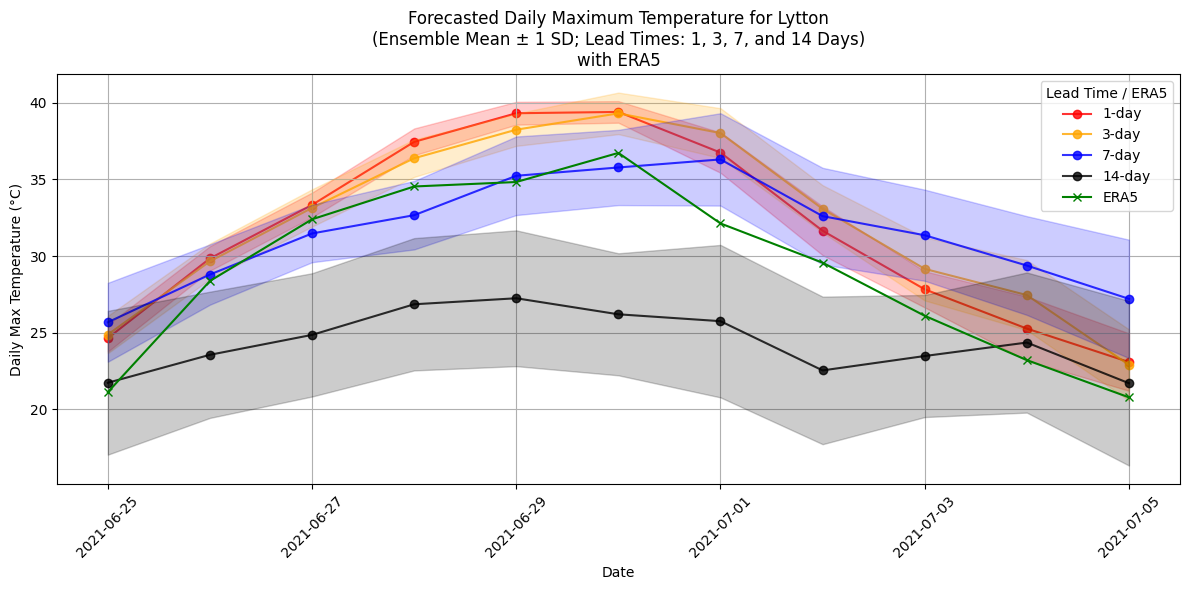

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the Cloud Storage paths for the combined daily forecast CSV files (for Lytton daily maximum temperature)
lead_files = {
    "14-day": "gs://gencast/daily_forecast_14day/lytton_daily_forecast_14day.csv",
    "7-day":  "gs://gencast/daily_forecast_7day/lytton_daily_forecast_7day.csv",
    "3-day":  "gs://gencast/daily_forecast_3day/lytton_daily_forecast_3day.csv",
    "1-day":  "gs://gencast/daily_forecast_1day/lytton_daily_forecast_1day.csv",
}

# Dictionary to store aggregated ensemble statistics for each lead time.
# Each CSV file is assumed to have columns:
#    - "date": the forecast date,
#    - "daily_max": the daily maximum temperature (in °C) for each ensemble member.
agg_results = {}

for lead, filepath in lead_files.items():
    # Load the file directly from Cloud Storage.
    df = pd.read_csv(filepath)
    # Ensure the 'date' column is parsed as datetime.
    df['date'] = pd.to_datetime(df['date'])
    # Convert 'daily_max' to numeric.
    df['daily_max'] = pd.to_numeric(df['daily_max'], errors='coerce')
    # Group by date and calculate the ensemble mean and standard deviation.
    agg = df.groupby('date')['daily_max'].agg(['mean', 'std']).reset_index()
    agg_results[lead] = agg

# Define the plotting order (we want to plot from shorter lead time upward).
order = ["1-day", "3-day", "7-day", "14-day"]

# Define colors and z-orders for each lead time.
colors = {
    "1-day": "red",
    "3-day": "orange",
    "7-day": "blue",
    "14-day": "black"
}
zorders = {
    "1-day": 1,
    "3-day": 2,
    "7-day": 3,
    "14-day": 4
}

plt.figure(figsize=(12, 6))

for lead in order:
    agg = agg_results[lead]
    plt.plot(agg['date'], agg['mean'],
             marker='o', label=lead, color=colors[lead],
             alpha=0.8, zorder=zorders[lead])
    plt.fill_between(agg['date'],
                     agg['mean'] - agg['std'],
                     agg['mean'] + agg['std'],
                     color=colors[lead], alpha=0.2, zorder=zorders[lead])

# --- Now, add ERA5's temperature line ---

# Extract ERA5's 2m temperature at Lytton's location.
# (Assumes ds is an xarray Dataset already loaded with variable "t2m", and time coordinate "valid_time".)
lat_lytton = 50.68
lon_lytton = -121.95

# Select nearest ERA5 values at Lytton; convert from Kelvin to Celsius.
da = ds['t2m'].sel(latitude=lat_lytton, longitude=lon_lytton, method='nearest') - 273.15

# Convert the DataArray to a pandas Series with valid_time as index.
series = pd.Series(da.values, index=pd.to_datetime(da.valid_time.values))

# Group by date and compute the daily maximum.
daily_max_era5 = series.groupby(series.index.date).max().reset_index()
daily_max_era5.columns = ['date', 'max']
daily_max_era5['date'] = pd.to_datetime(daily_max_era5['date'])

# Truncate ERA5 data so that only dates up to 2021-07-05 are retained.
end_date = pd.to_datetime("2021-07-05")
daily_max_era5 = daily_max_era5[daily_max_era5['date'] <= end_date]

# Plot the ERA5 daily max line in green with "x" markers.
plt.plot(daily_max_era5['date'], daily_max_era5['max'],
         marker='x', linestyle='-', color='green', label='ERA5', zorder=5)

plt.xlabel("Date")
plt.ylabel("Daily Max Temperature (°C)")
plt.title("Forecasted Daily Maximum Temperature for Lytton\n(Ensemble Mean ± 1 SD; Lead Times: 1, 3, 7, and 14 Days)\nwith ERA5")
plt.legend(title="Lead Time / ERA5")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecast_daily_max_Lytton.png", dpi=1000)
plt.show()

<Figure size 640x480 with 0 Axes>

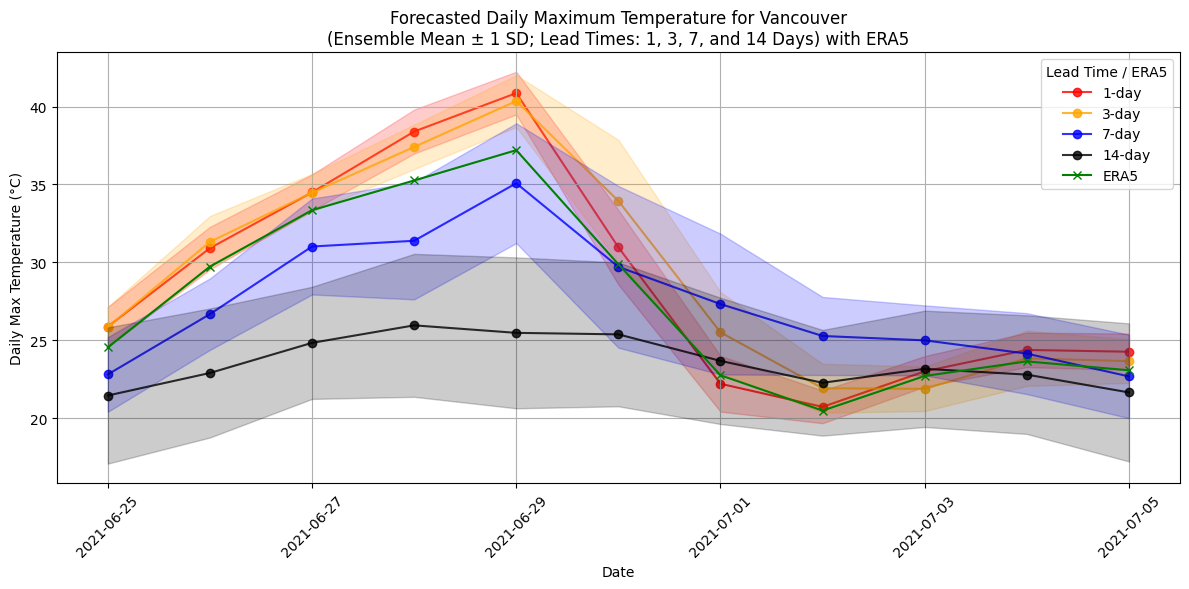

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the Cloud Storage paths for the combined daily forecast CSV files for Vancouver.
lead_files = {
    "14-day": "gs://gencast/daily_forecast_14day/vancouver_daily_forecast_14day.csv",
    "7-day":  "gs://gencast/daily_forecast_7day/vancouver_daily_forecast_7day.csv",
    "3-day":  "gs://gencast/daily_forecast_3day/vancouver_daily_forecast_3day.csv",
    "1-day":  "gs://gencast/daily_forecast_1day/vancouver_daily_forecast_1day.csv",
}

agg_results = {}
for lead, filepath in lead_files.items():
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    # Use the "daily_max" column for maximum
    df['daily_max'] = pd.to_numeric(df['daily_max'], errors='coerce')
    agg = df.groupby('date')['daily_max'].agg(['mean', 'std']).reset_index()
    agg_results[lead] = agg

order = ["1-day", "3-day", "7-day", "14-day"]
colors = {"1-day": "red", "3-day": "orange", "7-day": "blue", "14-day": "black"}
zorders = {"1-day": 1, "3-day": 2, "7-day": 3, "14-day": 4}

plt.figure(figsize=(12,6))
for lead in order:
    agg = agg_results[lead]
    plt.plot(agg['date'], agg['mean'], marker='o', label=lead, color=colors[lead],
             alpha=0.8, zorder=zorders[lead])
    plt.fill_between(agg['date'], agg['mean'] - agg['std'], agg['mean'] + agg['std'],
                     color=colors[lead], alpha=0.2, zorder=zorders[lead])

# Add ERA5's daily max for Vancouver.
# Select nearest ERA5 value at Vancouver's location.
lat_vancouver = 49.28
lon_vancouver = -123.12
da = ds['t2m'].sel(latitude=lat_vancouver, longitude=lon_vancouver, method='nearest') - 273.15
series = pd.Series(da.values, index=pd.to_datetime(da.valid_time.values))
daily_max_era5 = series.groupby(series.index.date).max().reset_index()
daily_max_era5.columns = ['date', 'max']
daily_max_era5['date'] = pd.to_datetime(daily_max_era5['date'])
daily_max_era5 = daily_max_era5[daily_max_era5['date'] <= pd.to_datetime("2021-07-05")]

plt.plot(daily_max_era5['date'], daily_max_era5['max'], marker='x', linestyle='-',
         color='green', label='ERA5', zorder=5)

plt.xlabel("Date")
plt.ylabel("Daily Max Temperature (°C)")
plt.title("Forecasted Daily Maximum Temperature for Vancouver\n(Ensemble Mean ± 1 SD; Lead Times: 1, 3, 7, and 14 Days) with ERA5")
plt.legend(title="Lead Time / ERA5")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasted_daily_max_Vancouver.png", dpi=1000)  # Export the figure
plt.show()


## Daily Mean

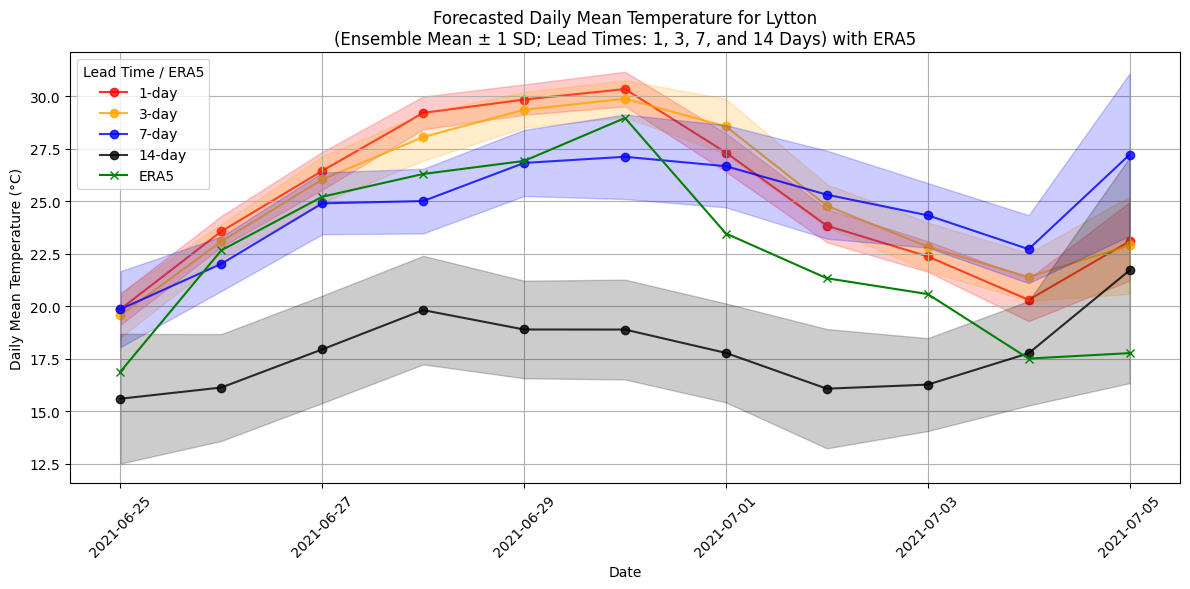

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the Cloud Storage paths for the combined daily forecast CSV files for Lytton.
lead_files = {
    "14-day": "gs://gencast/daily_forecast_14day/lytton_daily_forecast_14day.csv",
    "7-day":  "gs://gencast/daily_forecast_7day/lytton_daily_forecast_7day.csv",
    "3-day":  "gs://gencast/daily_forecast_3day/lytton_daily_forecast_3day.csv",
    "1-day":  "gs://gencast/daily_forecast_1day/lytton_daily_forecast_1day.csv",
}

agg_results = {}
for lead, filepath in lead_files.items():
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    # Use the "daily_avg" column for mean
    df['daily_avg'] = pd.to_numeric(df['daily_avg'], errors='coerce')
    # Aggregate ensemble daily average values.
    agg = df.groupby('date')['daily_avg'].agg(['mean', 'std']).reset_index()
    agg_results[lead] = agg

# Define plotting order, colors, and zorders.
order = ["1-day", "3-day", "7-day", "14-day"]
colors = {"1-day": "red", "3-day": "orange", "7-day": "blue", "14-day": "black"}
zorders = {"1-day": 1, "3-day": 2, "7-day": 3, "14-day": 4}

plt.figure(figsize=(12,6))
for lead in order:
    agg = agg_results[lead]
    plt.plot(agg['date'], agg['mean'], marker='o', label=lead, color=colors[lead],
             alpha=0.8, zorder=zorders[lead])
    plt.fill_between(agg['date'], agg['mean'] - agg['std'], agg['mean'] + agg['std'],
                     color=colors[lead], alpha=0.2, zorder=zorders[lead])

# Add ERA5's daily mean (average) for Lytton.
# Assumes ds is already loaded and has variable "t2m", and time coordinate "valid_time"
lat_lytton = 50.68
lon_lytton = -121.95
da = ds['t2m'].sel(latitude=lat_lytton, longitude=lon_lytton, method='nearest') - 273.15
series = pd.Series(da.values, index=pd.to_datetime(da.valid_time.values))
daily_avg_era5 = series.groupby(series.index.date).mean().reset_index()
daily_avg_era5.columns = ['date', 'avg']
daily_avg_era5['date'] = pd.to_datetime(daily_avg_era5['date'])
daily_avg_era5 = daily_avg_era5[daily_avg_era5['date'] <= pd.to_datetime("2021-07-05")]

plt.plot(daily_avg_era5['date'], daily_avg_era5['avg'], marker='x', linestyle='-',
         color='green', label='ERA5', zorder=5)

plt.xlabel("Date")
plt.ylabel("Daily Mean Temperature (°C)")
plt.title("Forecasted Daily Mean Temperature for Lytton\n(Ensemble Mean ± 1 SD; Lead Times: 1, 3, 7, and 14 Days) with ERA5")
plt.legend(title="Lead Time / ERA5")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasted_daily_mean_Lytton.png", dpi=1000)  # Export the figure
plt.show()

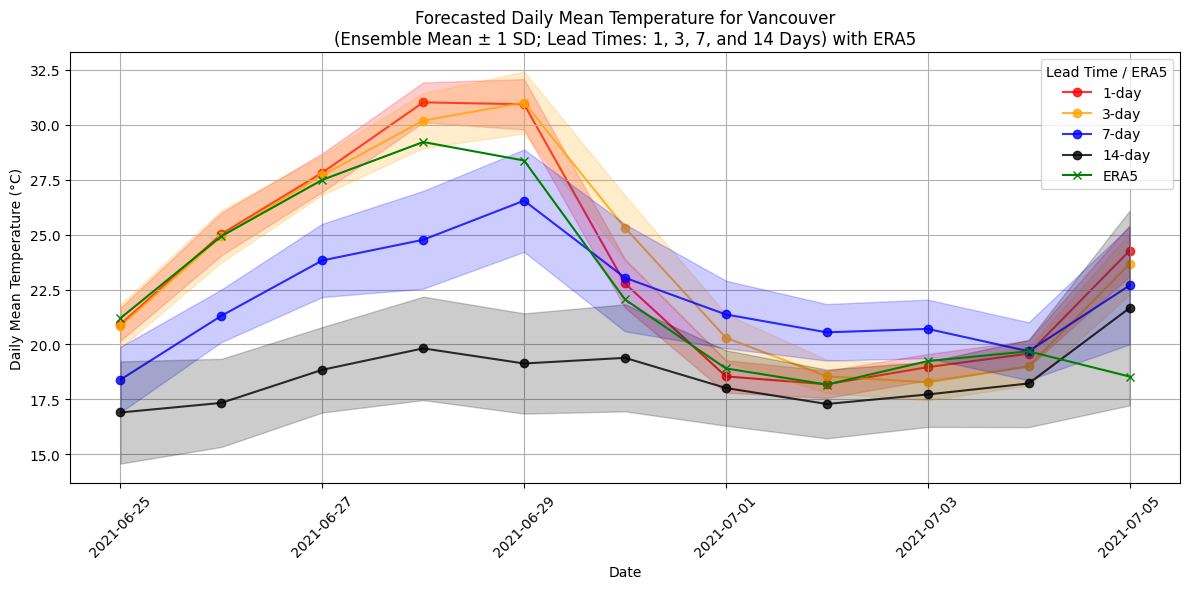

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the Cloud Storage paths for the combined daily forecast CSV files for Vancouver.
lead_files = {
    "14-day": "gs://gencast/daily_forecast_14day/vancouver_daily_forecast_14day.csv",
    "7-day":  "gs://gencast/daily_forecast_7day/vancouver_daily_forecast_7day.csv",
    "3-day":  "gs://gencast/daily_forecast_3day/vancouver_daily_forecast_3day.csv",
    "1-day":  "gs://gencast/daily_forecast_1day/vancouver_daily_forecast_1day.csv",
}

agg_results = {}
for lead, filepath in lead_files.items():
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    # Use the "daily_avg" column for mean.
    df['daily_avg'] = pd.to_numeric(df['daily_avg'], errors='coerce')
    agg = df.groupby('date')['daily_avg'].agg(['mean', 'std']).reset_index()
    agg_results[lead] = agg

order = ["1-day", "3-day", "7-day", "14-day"]
colors = {"1-day": "red", "3-day": "orange", "7-day": "blue", "14-day": "black"}
zorders = {"1-day": 1, "3-day": 2, "7-day": 3, "14-day": 4}

plt.figure(figsize=(12,6))
for lead in order:
    agg = agg_results[lead]
    plt.plot(agg['date'], agg['mean'], marker='o', label=lead, color=colors[lead],
             alpha=0.8, zorder=zorders[lead])
    plt.fill_between(agg['date'], agg['mean'] - agg['std'], agg['mean'] + agg['std'],
                     color=colors[lead], alpha=0.2, zorder=zorders[lead])

# Add ERA5's daily mean for Vancouver.
lat_vancouver = 49.28
lon_vancouver = -123.12
da = ds['t2m'].sel(latitude=lat_vancouver, longitude=lon_vancouver, method='nearest') - 273.15
series = pd.Series(da.values, index=pd.to_datetime(da.valid_time.values))
daily_avg_era5 = series.groupby(series.index.date).mean().reset_index()
daily_avg_era5.columns = ['date', 'avg']
daily_avg_era5['date'] = pd.to_datetime(daily_avg_era5['date'])
daily_avg_era5 = daily_avg_era5[daily_avg_era5['date'] <= pd.to_datetime("2021-07-05")]

plt.plot(daily_avg_era5['date'], daily_avg_era5['avg'], marker='x', linestyle='-',
         color='green', label='ERA5', zorder=5)

plt.xlabel("Date")
plt.ylabel("Daily Mean Temperature (°C)")
plt.title("Forecasted Daily Mean Temperature for Vancouver\n(Ensemble Mean ± 1 SD; Lead Times: 1, 3, 7, and 14 Days) with ERA5")
plt.legend(title="Lead Time / ERA5")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasted_daily_mean_Vancouver.png", dpi=300)  # Export the figure
plt.show()

In [ ]:
agg_results

## debug below

In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1. Configuration
# ---------------------------
csv_files = "gs://gencast/weathernext/weathernext_bc_heatwave_2021_full_14days/*.csv"

cols = [
    "init_time",
    "forecast_time",
    "geography_polygon_text",
    "geography_text",
    "ensemble_member",
    "total_precipitation_12hr",
    "u_component_100m",
    "v_component_100m",
    "u_component_10m",
    "v_component_10m",
    "temp_2m",
    "mean_sea_level_pressure",
    "sea_surface_temperature"
]

useful_cols = [
        "init_time",
    "forecast_time",
    "geography_polygon_text",
    "geography_text",
    "ensemble_member",
        "temp_2m"
]

In [ ]:
# ---------------------------
# 2. Read and Quality-Check Data
# ---------------------------
# Read CSVs lazily using Dask DataFrame.
ddf = dd.read_csv(csv_files, names=cols, header=None, assume_missing=True)
print(f"Original dataframe dimensions: {ddf.shape}")

# Convert 'init_time' and 'forecast_time' to datetime
ddf['init_time'] = dd.to_datetime(ddf['init_time'], errors='coerce')
ddf['forecast_time'] = dd.to_datetime(ddf['forecast_time'], errors='coerce')

# Filter to useful columns only
ddf_filtered = ddf[useful_cols]
print(f"Filtered dataframe dimensions: {ddf_filtered.shape}")

# Add forecast_date column for daily grouping using the datetime accessor
ddf_filtered['forecast_date'] = ddf_filtered['forecast_time'].dt.floor('D')

# Group by forecast run and date to compute daily statistics
daily_stats = ddf_filtered.groupby(["init_time", "forecast_date"]).agg({
    "temp_2m": ["mean", "max"]
}).reset_index()

# Flatten the multi-index columns.
daily_stats.columns = ["init_time", "forecast_date", "daily_mean", "daily_max"]

# Compute the daily statistics DataFrame (triggers computation)
daily_stats_df = daily_stats.compute()

# Check dimensions of the final aggregated dataframe
print(f"Final daily stats dataframe dimensions: {daily_stats_df.shape}")

print("=== Daily Temperature Statistics (Head) ===")
print(daily_stats_df.head())

In [ ]:
ddf.info()

In [ ]:
# ---------------------------
# 3. (Optional) Aggregation & Further Analysis
# ---------------------------
# For example, suppose you want to compute run-level statistics from the ensemble values.
# Here, each unique (init_time, forecast_time) represents one forecast run.
# You might compute the run-level mean and maximum 2m temperature as follows:

# Group by forecast run and compute aggregate statistics on the 2m temperature.
run_stats = ddf.groupby(["init_time", "forecast_time"]).agg({
    "temp_2m": ["mean", "max"]
}).reset_index()

# Flatten the multi-index columns.
run_stats.columns = ["init_time", "forecast_time", "run_mean", "run_max"]

# Compute the aggregated run-level DataFrame (this will trigger computation).
run_stats_df = run_stats.compute()
print("=== Run-level Aggregated Statistics (Head) ===")
print(run_stats_df.head())

In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1. Configuration
# ---------------------------
# Path to the CSV files for the 14-day lead dataset (adjust path as needed)
csv_files = "gs://gencast/weathernext/weathernext_bc_heatwave_2021_full_14days/*.csv"

# Define column names based on your exported schema.
# (Note: Column names have been renamed for easier handling in Python)
cols = [
    "init_time",                   # forecast initialization time
    "forecast_time",               # forecast valid time
    "geography_polygon_text",      # domain polygon (WKT)
    "geography_text",              # additional geography info
    "ensemble_member",             # ensemble member identifier
    "total_precipitation_12hr",
    "u_component_100m",            # was "100m_u_component_of_wind"
    "v_component_100m",            # was "100m_v_component_of_wind"
    "u_component_10m",             # was "10m_u_component_of_wind"
    "v_component_10m",             # was "10m_v_component_of_wind"
    "temp_2m",                     # was "2m_temperature"
    "mean_sea_level_pressure",
    "sea_surface_temperature"
]


# Quick quality check: print the first 10 rows.
print("=== HEAD ===")
print(ddf.head(10))

# Retrieve the tail (last 10 rows) by computing the last partition.
# Note: ddf.get_partition(n) returns a Dask DataFrame for that partition.
last_partition = ddf.get_partition(ddf.npartitions - 1)
# Compute the partition first then take its tail:
tail_df = last_partition.compute().tail(10)
print("=== TAIL ===")
print(tail_df)

# ---------------------------
# 3. (Optional) Aggregation & Further Analysis
# ---------------------------
# For example, suppose you want to compute run-level statistics from the ensemble values.
# Here, each unique (init_time, forecast_time) represents one forecast run.
# You might compute the run-level mean and maximum 2m temperature as follows:

# Group by forecast run and compute aggregate statistics on the 2m temperature.
run_stats = ddf.groupby(["init_time", "forecast_time"]).agg({
    "temp_2m": ["mean", "max"]
}).reset_index()

# Flatten the multi-index columns.
run_stats.columns = ["init_time", "forecast_time", "run_mean", "run_max"]

# Compute the aggregated run-level DataFrame (this will trigger computation).
run_stats_df = run_stats.compute()
print("=== Run-level Aggregated Statistics (Head) ===")
print(run_stats_df.head())

# ---------------------------
# 4. Fast Plotting (Template)
# ---------------------------
# For fast plotting, you may wish to further aggregate the run-level stats by forecast_time.
# For example, compute the overall daily mean and max (and if needed, SD across runs).

# Group by forecast_time to aggregate across forecast runs.
agg_stats = run_stats_df.groupby("forecast_time").agg({
    "run_mean": ["mean", "std"],
    "run_max": ["mean", "std"]
}).reset_index()

# Flatten the columns.
agg_stats.columns = ["forecast_time", "daily_mean", "daily_mean_std", "daily_max", "daily_max_std"]
agg_stats["forecast_time"] = pd.to_datetime(agg_stats["forecast_time"])

# Plot the aggregated daily mean and max with error bars showing SD.
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(agg_stats["forecast_time"], agg_stats["daily_mean"], yerr=agg_stats["daily_mean_std"],
            fmt='o-', color='blue', label="Daily Mean (±SD)")
ax.errorbar(agg_stats["forecast_time"], agg_stats["daily_max"], yerr=agg_stats["daily_max_std"],
            fmt='s--', color='red', label="Daily Max (±SD)")

ax.set_xlabel("Forecast Time")
ax.set_ylabel("2m Temperature (°C)")
ax.set_title("Daily Aggregated 2m Temperature (14-Day Lead) from Ensemble Predictions")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# ---------------------------
# 5. Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Daily mean ± SD
ax.errorbar(
    agg["date"],
    agg["daily_mean"],
    yerr=agg["daily_mean_sd"],
    fmt="o-",
    label="Daily Mean (±1 SD)"
)

# Daily max ± SD
ax.errorbar(
    agg["date"],
    agg["daily_max"],
    yerr=agg["daily_max_sd"],
    fmt="s--",
    label="Daily Max (±1 SD)"
)

ax.set_xlabel("Date")
ax.set_ylabel("2 m Temperature (K)")
ax.set_title("Lytton Area: Daily Mean & Max 2 m Temperature (2021‑06‑25 to 2021‑07‑05)")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()